# **Dataset Description**

- **status** : status of the debtor's checking account with the bank (categorical)
  
- **duration** : credit duration in months (quantitative)

- **credit_history** : history of compliance with previous or concurrent credit contracts (categorical)
  
- **purpose** : purpose for which the credit is needed (categorical)
  
- **amount** : credit amount in DM (quantitative; result of monotonic transformation; actual data and type of transformation unknown)

- **savings** : debtor's savings (categorical)
  
- **employment_duration** : duration of debtor's employment with current employer (ordinal; discretized quantitative)
  
- **installment_rate** : credit installments as a percentage of debtor's disposable income (ordinal; discretized quantitative)

- **personal_status_sex** : combined information on sex and marital status; categorical; sex cannot be recovered from the variable, because male singles and female non-singles are coded with the same code (2); female widows cannot
be easily classified, because the code table does not list them in any of the female categories
  
- **other_debtors :** Is there another debtor or a guarantor for the credit? (categorical)

- **present_residence :** length of time (in years) the debtor lives in the present residence (ordinal; discretized quantitative)

- **property :** the debtor's most valuable property, i.e. the highest possible code is used. Code 2 is used, if codes 3 or 4 are not applicable and there is a car or any other relevant property that does not fall under variable savings. (ordinal)
  
- **age :**age in years (quantitative)

- **other_installment_plans :**installment plans from providers other than the credit-giving bank (categorical)
  
- **housing :**type of housing the debtor lives in (categorical)
  
- **number_credits :**number of credits including the current one the debtor has (or had) at this bank (ordinal, discretized quantitative); contrary to Fahrmeir and HamerleÃ¢â‚¬â„¢s (1984) statement, the original data values are not available.

- **job :**quality of debtor's job (ordinal)
  
- **people_liable :**number of persons who financially depend on the debtor (i.e., are entitled to maintenance) (binary, discretized quantitative)

- **telephone :**Is there a telephone landline registered on the debtor's name? (binary; remember that the data are from the 1970s)
  
- **foreign_worker :**Is the debtor a foreign worker? (binary)
  
- **credit_risk :**Has the credit contract been complied with (good) or not (bad) ? (binary)

Further details can be referred from the **codetable.txt** file.

# **Install necessary packages**

In [1]:
!pip install cassandra-driver
!python -c 'import cassandra; print ("cassandra driver version = " + cassandra.__version__)'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 5.0 MB/s 
cassandra driver version = 3.25.0


# **Import Libraries and Dataset**

In [2]:
import logging

logger = logging.getLogger()

file_handler = logging.FileHandler(filename='scr_eda_log.log', mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.setLevel(logging.DEBUG)
logger.info('FILE STARTS RUNNING!')

INFO:root:FILE STARTS RUNNING!


In [3]:
import cassandra
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import os
import csv
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
from IPython.display import Javascript
def adust_height():
  display(Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight:5000})"))
get_ipython().events.register('pre_run_cell', adust_height)

In [5]:
logger.info('Libraries imported..')

<IPython.core.display.Javascript object>

INFO:root:Libraries imported..


**Connect to Cassandra database**

In [6]:
logger.info('Connecting to database..')

<IPython.core.display.Javascript object>

INFO:root:Connecting to database..


In [7]:
ASTRA_DB_TOKEN="AstraCS:iQyLbOiYUpxBBjOpKxYMKvnQ"
ASTRA_DB_SECURE_BUNDLE_LOCATION="/content/secure-connect-ineuron-3.zip"

!env | grep ASTRA

<IPython.core.display.Javascript object>

In [8]:
username = "token"
token = ASTRA_DB_TOKEN
secureBundleLocation = ASTRA_DB_SECURE_BUNDLE_LOCATION

<IPython.core.display.Javascript object>

In [9]:
# Database Name : Ineuron_3

keyspace = 'german_credit'

table_name = 'gcr1'

client_id = 'iQyLbOiYUpxBBjOpKxYMKvnQ'

client_secret = '6RXh7D4EW,3KrwO_xGASH0ElpjiLBQYH97SzAgatFMN,EXxYlPWMm96LtB1RIE_fm6bPyClhM74kDtXdBAt3LegqcCdErrU_Jj9OsH9OSW+2J1G+FOG4yop8uim9v0Go'

cloud_config = {'secure_connect_bundle':'/content/secure-connect-ineuron-3.zip'}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

<IPython.core.display.Javascript object>

DEBUG:cassandra.cluster:Connecting to cluster, contact points: [<SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65>, <SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7>, <SniEndPoint: 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b>]; protocol version: 66
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65 is now marked up
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7 is now marked up
DEBUG:cassandra.pool:Host 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b is now marked up
DEBUG:cassandra.cluster:[control connection] Opening 

In [10]:
logger.info('Database Connected.')

<IPython.core.display.Javascript object>

INFO:root:Database Connected.


In [11]:
session.execute("USE {keyspace};".format(keyspace=keyspace))

<IPython.core.display.Javascript object>

In [12]:
logger.info('Extracting data from database..')

<IPython.core.display.Javascript object>

INFO:root:Extracting data from database..


In [13]:
def pandas_factory(colnames, rows):
  return pd.DataFrame(rows, columns=colnames)

session.row_factory = pandas_factory
session.default_fetch_size = None

result = session.execute("SELECT * FROM {table_name};".format(table_name=table_name), timeout=None)

df=result._current_rows.sort_values('id')
df.head()

<IPython.core.display.Javascript object>

,id,age,amount,credit_history,credit_risk,duration,employment_duration,foreign_worker,housing,installment_rate,...,other_debtors,other_installment_plans,people_liable,personal_status_sex,present_residence,property,purpose,savings,status,telephone
296,0,21,1049,4,1,18,2,2,1,4,...,1,3,2,2,4,2,2,1,1,1
255,1,36,2799,4,1,9,3,2,1,2,...,1,3,1,3,2,1,0,1,1,1
312,2,23,841,2,1,12,4,2,1,2,...,1,3,2,2,4,1,9,2,2,1
989,3,39,2122,4,1,12,3,1,1,3,...,1,3,1,3,2,1,0,1,1,1
339,4,38,2171,4,1,12,3,1,2,4,...,1,1,2,3,4,2,0,1,1,1


In [14]:
logger.info('Data extraction completed.')

<IPython.core.display.Javascript object>

INFO:root:Data extraction completed.


In [15]:
import os
# Creating a folder to store all the graphs
os.mkdir('/content/Graphs')

<IPython.core.display.Javascript object>

# **Exploratory Data Analysis**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 296 to 892
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   id                       1000 non-null   int64
 1   age                      1000 non-null   int64
 2   amount                   1000 non-null   int64
 3   credit_history           1000 non-null   int64
 4   credit_risk              1000 non-null   int64
 5   duration                 1000 non-null   int64
 6   employment_duration      1000 non-null   int64
 7   foreign_worker           1000 non-null   int64
 8   housing                  1000 non-null   int64
 9   installment_rate         1000 non-null   int64
 10  job                      1000 non-null   int64
 11  number_credits           1000 non-null   int64
 12  other_debtors            1000 non-null   int64
 13  other_installment_plans  1000 non-null   int64
 14  people_liable            1000 non-null   int64
 15  per

In [ ]:
# Check for duplicates
df.duplicated().value_counts()

False    1000
dtype: int64

In [ ]:
# Confirm for missing values
df.isnull().sum()

id                         0
age                        0
amount                     0
credit_history             0
credit_risk                0
duration                   0
employment_duration        0
foreign_worker             0
housing                    0
installment_rate           0
job                        0
number_credits             0
other_debtors              0
other_installment_plans    0
people_liable              0
personal_status_sex        0
present_residence          0
property                   0
purpose                    0
savings                    0
status                     0
telephone                  0
dtype: int64

In [ ]:
logger.info('Exploratory Data Analysis starts...')

INFO:root:Exploratory Data Analysis starts...


**OBsERVATION:**

Excluding id column from the dataframe, we can observe that there are :
- 3 numerical variables.
- 17 categorical variables, out of which
  - 6 are ordinal categories and,
  - 11 are nominal categories.
- 1 target variable.

## **Basic Analysis**

In [ ]:
# Descriptive  statistics
df.describe()

,id,age,amount,credit_history,credit_risk,duration,employment_duration,foreign_worker,housing,installment_rate,...,other_debtors,other_installment_plans,people_liable,personal_status_sex,present_residence,property,purpose,savings,status,telephone
count,1000.000000,1000.00000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.54200,3271.24800,2.54500,0.700000,20.903000,3.384000,1.963000,1.928000,2.973000,...,1.145000,2.675000,1.845000,2.68200,2.845000,2.358000,2.828000,2.105000,2.577000,1.404000
std,288.819436,11.35267,2822.75176,1.08312,0.458487,12.058814,1.208306,0.188856,0.530186,1.118715,...,0.477706,0.705601,0.362086,0.70808,1.103718,1.050209,2.744439,1.580023,1.257638,0.490943
min,0.000000,19.00000,250.00000,0.00000,0.000000,4.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,249.750000,27.00000,1365.50000,2.00000,0.000000,12.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,3.000000,2.000000,2.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,499.500000,33.00000,2319.50000,2.00000,1.000000,18.000000,3.000000,2.000000,2.000000,3.000000,...,1.000000,3.000000,2.000000,3.00000,3.000000,2.000000,2.000000,1.000000,2.000000,1.000000
75%,749.250000,42.00000,3972.25000,4.00000,1.000000,24.000000,5.000000,2.000000,2.000000,4.000000,...,1.000000,3.000000,2.000000,3.00000,4.000000,3.000000,3.000000,3.000000,4.000000,2.000000
max,999.000000,75.00000,18424.00000,4.00000,1.000000,72.000000,5.000000,2.000000,3.000000,4.000000,...,3.000000,3.000000,2.000000,4.00000,4.000000,4.000000,10.000000,5.000000,4.000000,2.000000


In [ ]:
# Number of unique values for each column
df.nunique()

id                         1000
age                          53
amount                      923
credit_history                5
credit_risk                   2
duration                     33
employment_duration           5
foreign_worker                2
housing                       3
installment_rate              4
job                           4
number_credits                4
other_debtors                 3
other_installment_plans       3
people_liable                 2
personal_status_sex           4
present_residence             4
property                      4
purpose                      10
savings                       5
status                        4
telephone                     2
dtype: int64

**OBSERVATIONS**
- **Numerical variables** : duration, amount, age
- **Categorical** : status,	credit_history,	purpose, savings,	employment_duration,	installment_rate,	personal_status_sex,	other_debtors,	present_residence,	property,	other_installment_plans, housing,	number_credits,	job	people_liable,	telephone,	foreign_worker	

In [ ]:
df.columns

Index(['id', 'age', 'amount', 'credit_history', 'credit_risk', 'duration',
       'employment_duration', 'foreign_worker', 'housing', 'installment_rate',
       'job', 'number_credits', 'other_debtors', 'other_installment_plans',
       'people_liable', 'personal_status_sex', 'present_residence', 'property',
       'purpose', 'savings', 'status', 'telephone'],
      dtype='object')

## **Distribution of target variable**

In [16]:
df['credit_risk'].value_counts()

<IPython.core.display.Javascript object>

1    700
0    300
Name: credit_risk, dtype: int64

<IPython.core.display.Javascript object>

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal

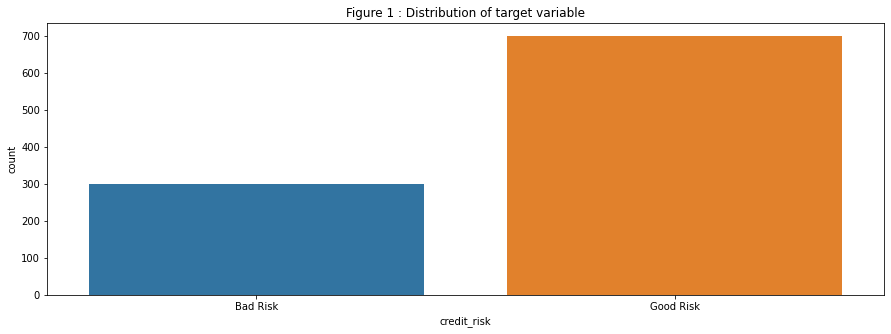

In [17]:
x_labels= ['Bad Risk', 'Good Risk']

fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 1 : Distribution of target variable')
plt.savefig('/content/Graphs/1.jpeg')
plt.show()

## **Numerical Variables**

### **Functions**

In [18]:
# Function to plot the distribution of numerical variable
def plot_num_var(var_name, var_label, fig_num):
  # Distribution of age of customers
  plt.figure(figsize = (25,5))
  plt.suptitle('Figure {} : Distribution of {}'.format(fig_num,var_label))

  plt.subplot(1,2,1)
  sns.histplot(data=df, x=var_name, bins=10)
  plt.title('Fig {}(a)'.format(fig_num))
  plt.xlabel(var_label)
  plt.ylabel('Count')
  file_path = '/content/Graphs/'+str(fig_num)+'_a.jpeg'
  plt.savefig(file_path)

  plt.subplot(1,2,2)
  sns.boxplot(data=df, x=var_name)
  plt.title('Fig {}(b)'.format(fig_num))
  plt.xlabel(var_label)
  file_path = '/content/Graphs/'+str(fig_num)+'_b.jpeg'
  plt.savefig(file_path)

  plt.show()

<IPython.core.display.Javascript object>

In [19]:
# Function to plot the distribution of numerical variable by credit_risk value
def plot_numvar_creditrisk(var_name, var_label, fig_num):
  # Distribution of age of customers
  plt.figure(figsize = (25,5))
  plt.suptitle('Figure {} : Distribution of {} by credit_risk'.format(fig_num,var_label))

  plt.subplot(1,2,1)
  sns.histplot(data=df, x=var_name, hue='credit_risk', bins=10)
  plt.title('Fig {}(a)'.format(fig_num))
  plt.xlabel(var_label)
  plt.ylabel('Count')
  file_path = '/content/Graphs/'+str(fig_num)+'_a.jpeg'
  plt.savefig(file_path)

  plt.subplot(1,2,2)
  sns.boxplot(data=df, x='credit_risk', y=var_name)
  plt.title('Fig {}(b)'.format(fig_num))
  plt.xlabel('Credit Risk Value')
  file_path = '/content/Graphs/'+str(fig_num)+'_b.jpeg'
  plt.savefig(file_path)

  plt.show()

<IPython.core.display.Javascript object>

### **Credit duration in months : 'duration'**

<IPython.core.display.Javascript object>

DEBUG:cassandra.connection:Received options response on connection (140630568859856) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Received options response on connection (140630538691408) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:358ca568-08f7-42a4-8574-b72c6a0af7b7
DEBUG:cassandra.connection:Received options response on connection (140631023150928) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Received options response on connection (140630538691024) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:7d78e9c1-0951-47e5-ac2c-283fe5fc2d65


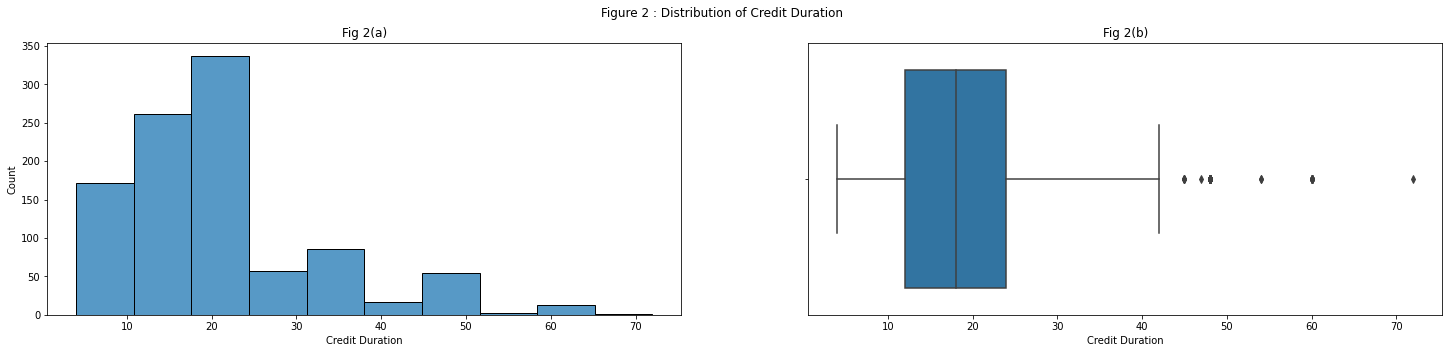

In [20]:
# Distribution of age of customers
plot_num_var('duration', 'Credit Duration', 2)

In [21]:
percentiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.99]

df['duration'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
10%         9.000000
20%        12.000000
25%        12.000000
30%        12.000000
40%        15.000000
50%        18.000000
60%        24.000000
70%        24.000000
75%        24.000000
80%        30.000000
90%        36.000000
99%        60.000000
max        72.000000
Name: duration, dtype: float64

<IPython.core.display.Javascript object>

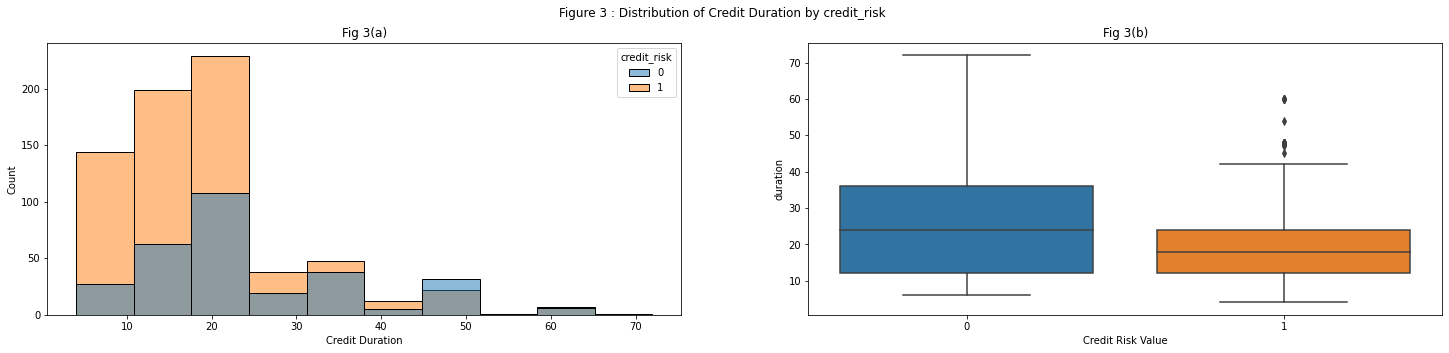

In [22]:
# Distribution of age of customers
plot_numvar_creditrisk('duration', 'Credit Duration', 3)

In [23]:
df.groupby('credit_risk')['duration'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,99%,max
credit_risk,,,,,,,,,,,,,,,,,
0,300.0,24.860000,13.282639,6.0,12.0,12.0,12.0,17.4,18.0,24.0,24.0,30.0,36.0,36.0,48.0,60.00,72.0
1,700.0,19.207143,11.079564,4.0,6.0,10.0,12.0,12.0,12.0,18.0,20.0,24.0,24.0,24.0,36.0,54.06,60.0


**OBSERVATION :**
- The majority of the credit durations lie between 10 and 25 months.
- The durations for credit_risk categories(0 and 1), are somewhat proportional.
- The mean duration of both the credit_risk category shows a significant difference difference. So we might have to assume that 'duration' might be a good predictor for our model.

**Hypothesis Testing : T-test**

H0 : There **IS NO** significant difference between means of duration based on credit_risk value

H1 : There **IS** significant difference between means of duration based on credit_risk value

In [24]:
# Statistical test to determine whether to reject or accept H0
duration_0 = df[df['credit_risk']==0]['duration']
duration_1 = df[df['credit_risk']==1]['duration']

_, p_value = stats.ttest_ind(duration_0,duration_1,equal_var=False)

if(p_value<0.05):
  print('Reject null hypothesis')
else:
  print('Do not reject null hypotheis')

<IPython.core.display.Javascript object>

Reject null hypothesis


**CONCLUSION :** Therefore, we reject null hypothesis, which means there is a significant difference between means of duration based on credit_risk value.
We can also conclude that 'duration' might be a good predictor variable for our model.

### **Age of the customer : 'age'**

<IPython.core.display.Javascript object>

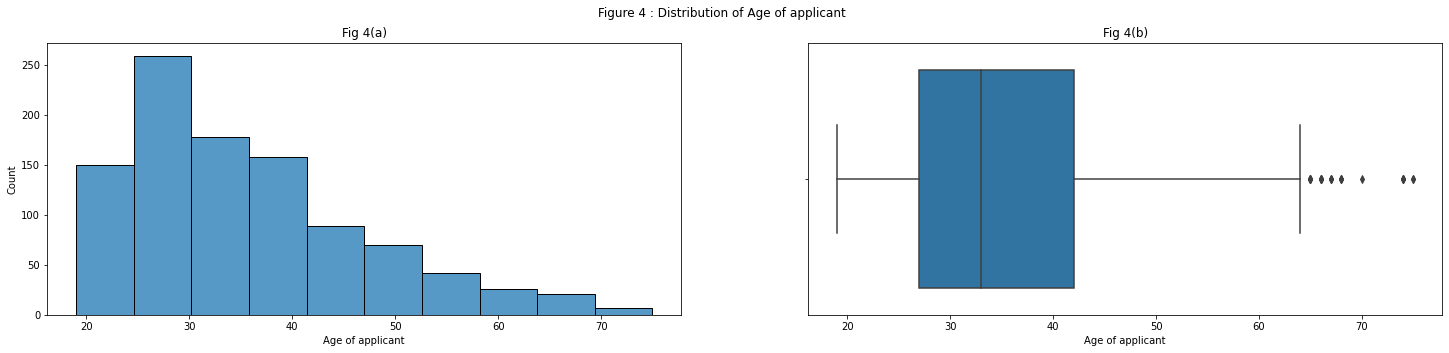

In [25]:
# Distribution of age of customers
plot_num_var('age', 'Age of applicant', 4)

In [26]:
df['age'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

count    1000.00000
mean       35.54200
std        11.35267
min        19.00000
10%        23.00000
20%        26.00000
25%        27.00000
30%        28.00000
40%        30.00000
50%        33.00000
60%        36.00000
70%        39.00000
75%        42.00000
80%        44.00000
90%        52.00000
99%        67.01000
max        75.00000
Name: age, dtype: float64

<IPython.core.display.Javascript object>

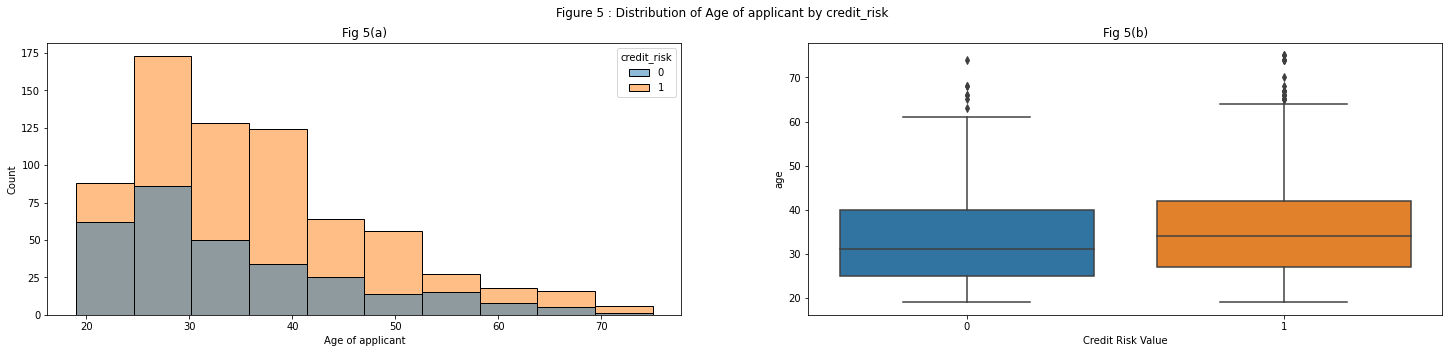

In [27]:
# Distribution of age of customers by credit_risk value
plot_numvar_creditrisk('age', 'Age of applicant', 5)

In [28]:
df.groupby('credit_risk')['age'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,99%,max
credit_risk,,,,,,,,,,,,,,,,,
0,300.0,33.96,11.225199,19.0,23.0,24.0,25.0,26.0,28.0,31.0,33.0,37.0,40.0,42.2,51.1,66.02,74.0
1,700.0,36.22,11.347428,19.0,24.0,26.0,27.0,28.7,31.0,34.0,36.0,40.0,42.0,45.0,52.0,67.01,75.0


**OBSERVATIONS :**
- Maority of the credit applicants are within the age group 25-45 yrs old, with a very few over 65 yrs.
- The age of applicants by credit risk value also seem to be proportional; the mean, median and the values at each percentile are either equal or close by.
- Therefore, it might be safe to assume that age does not really prove to be a good predictor for our classification model.

Nonetheless, we perform a statistical test to test/prove our assumption.

**Hypothesis Testing : T-test**

H0 : There IS NO significant difference between means of ages based on credit_risk value

H1 : There IS significant difference between means of ages based on credit_risk value


In [29]:
# Statistical test to determine if we should reject age as a good predictor variable
age_0 = df[df['credit_risk']==0]['age']
age_1 = df[df['credit_risk']==1]['age']

_, p_value = stats.ttest_ind(age_0,age_1,equal_var=False)

if(p_value<0.05):
  print('Reject null hypothesis')
else:
  print('Do not reject null hypotheis')

<IPython.core.display.Javascript object>

Reject null hypothesis


**CONCLUSION :** Contrary to our assumption, the statistical test tells us that age will prove as a good predictor for our model

### **Credit Amount : 'amount'**

<IPython.core.display.Javascript object>

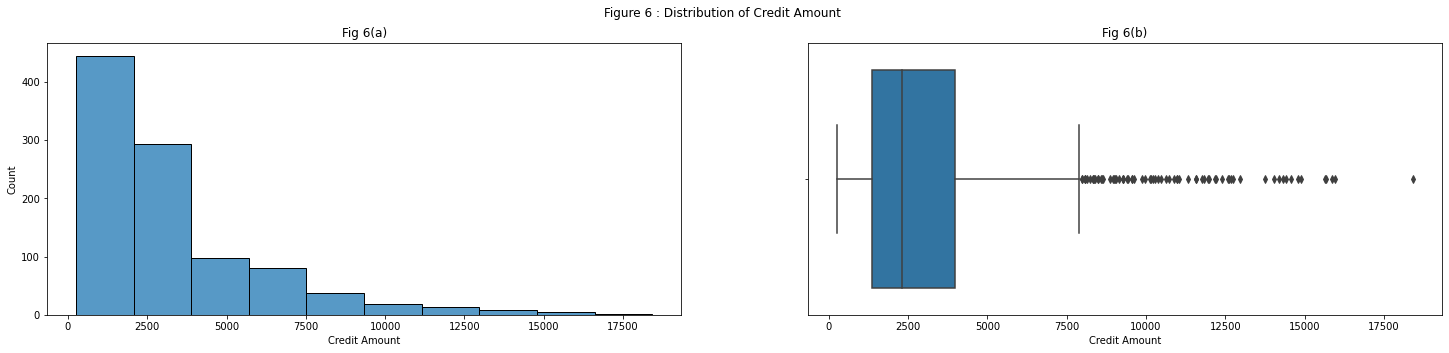

In [30]:
# Distribution of credit amount
plot_num_var('amount', 'Credit Amount', 6)

In [31]:
df['amount'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

count     1000.00000
mean      3271.24800
std       2822.75176
min        250.00000
10%        934.70000
20%       1262.00000
25%       1365.50000
30%       1479.40000
40%       1906.80000
50%       2319.50000
60%       2852.40000
70%       3590.00000
75%       3972.25000
80%       4720.00000
90%       7179.40000
99%      14180.39000
max      18424.00000
Name: amount, dtype: float64

<IPython.core.display.Javascript object>

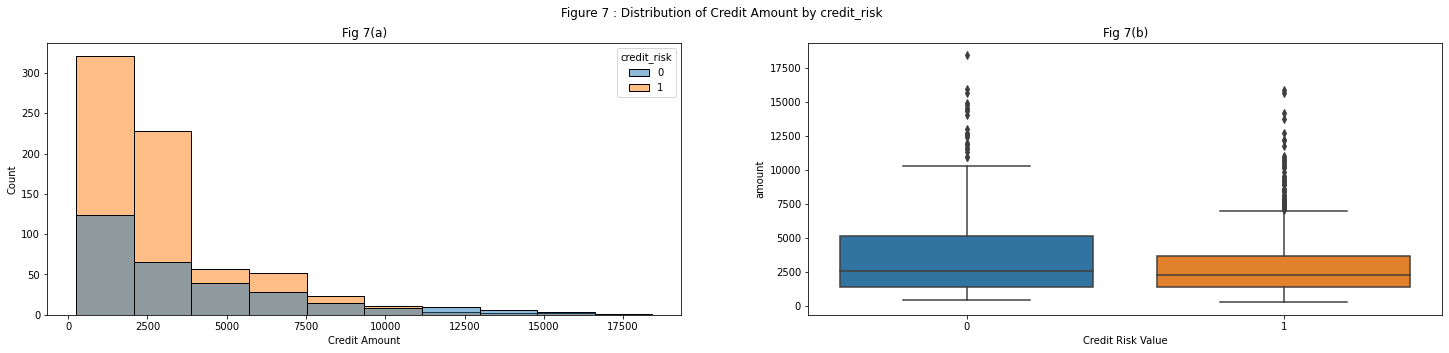

In [32]:
# Distribution of credit amount by credit_risk
plot_numvar_creditrisk('amount', 'Credit Amount', 7)

In [33]:
df.groupby('credit_risk')['amount'].describe(percentiles=percentiles)

<IPython.core.display.Javascript object>

,count,mean,std,min,10%,20%,25%,30%,40%,50%,60%,70%,75%,80%,90%,99%,max
credit_risk,,,,,,,,,,,,,,,,,
0,300.0,3938.126667,3535.818955,433.0,929.7,1245.8,1352.5,1524.6,1984.2,2574.5,3384.8,4457.4,5141.50,6424.4,8983.6,14903.76,18424.0
1,700.0,2985.442857,2401.495579,250.0,935.9,1263.6,1375.5,1474.0,1859.2,2244.0,2743.8,3384.2,3634.75,4024.2,6318.7,11764.09,15857.0


**OBSERVATIONS :**
- Majority of the credit amounts lie between 1000 to 4000 DM.
- When subcategorized based on credit_risk value, we see that the credit amounts are proportinal. But the mean amount for both risk categories are different, which implies that 'amount' might be a good predictor for our model.

**Hypothesis Testing : T-test**

H0 : There IS NO significant difference between means of ages based on credit_risk value

H1 : There IS significant difference between means of ages based on credit_risk value

In [34]:
# Statistical test to determine if we should reject age as a good predictor variable
amount_0 = df[df['credit_risk']==0]['amount']
amount_1 = df[df['credit_risk']==1]['amount']

_, p_value = stats.ttest_ind(amount_0,amount_1,equal_var=False)

if(p_value<0.05):
  print('Reject null hypothesis')
else:
  print('Do not reject null hypotheis')

<IPython.core.display.Javascript object>

Reject null hypothesis


**CONCLUSION :** Statistical test indicates that our assumption is correct and 'amount' can be considered a good predictor for our model.

## **Categorical Variables**

We know that we have 6 ordinal variable and 11 nominal variables.
First, we shall explore the ordinal and then nominal variables, one by one.

**Ordinal :** employment_duration, installment_rate, present_residence, property,  job, number_credits

**Nominal :** status, credit_history, purpose, savings, personal_status_sex, other_debtors, other_installment_plans, housing, telephone, foreign_worker, people_liable

### **Functions**

In [35]:
def plotting_percentages(df, col, target, fig_num, x_labels):
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    #order_list = list(df[col].unique())
    #order_list.sort()

    # Plot the figure
    sns.set(font_scale=1.5)
    g = sns.catplot(x=x, y='percent', hue=y,kind='bar', data=temp_df, height=6, aspect=3)
    g.ax.set_xticklabels(x_labels)
    g.ax.set_ylim(0,100)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        
    # Set labels and title
    plt.title(f'Figure {fig_num}(b) : {col.title()} By Percent {target.title()}')
    plt.xlabel(f'{col.title()}')
               
    plt.ylabel(f'{target.title()} Percentage', 
               fontdict={'fontsize': 20})
    file_path = '/content/Graphs/' + str(fig_num) + '_b.jpeg'
    plt.savefig(file_path)
    return g

<IPython.core.display.Javascript object>

In [36]:
def chisq_test(df, cat_var):
    # Creating an empty list of final selected predictors
    #SelectedPredictors=[]

    CrossTabResult=pd.crosstab(index=df['credit_risk'], columns=df[cat_var])
    ChiSqResult = chi2_contingency(CrossTabResult)
        
    # If the ChiSq P-Value is <0.05, that means we reject H0
    if (ChiSqResult[1] < 0.05):
        print('P-Value :', ChiSqResult[1])
        print('\'',cat_var,'\' IS CORRELATED with \'credit_risk\'')
    else:
        print('P-Value :', ChiSqResult[1])
        print(f'\'{cat_var}\' IS NOT CORRELATED with credit_risk')        
            

<IPython.core.display.Javascript object>

### **Duration of debtor's employment with current employer : 'employment_duration'**



In [37]:
df['employment_duration'].unique()

<IPython.core.display.Javascript object>

array([2, 3, 4, 1, 5])

As per codetable.txt,
- 1 : unemployed      
- 2 : < 1 yr          
- 3 : 1 <= ... < 4 yrs
- 4 : 4 <= ... < 7 yrs
- 5 : >= 7 yrs   

In [38]:
x_labels = ['Unemployed', 'Less than 1 yr', 'Between 1-4 yrs', 'Between 4-7 yrs', 'More tan 7 yrs']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

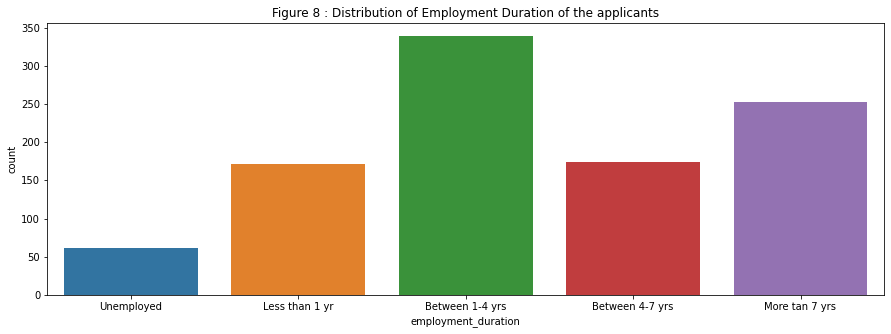

In [39]:
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='employment_duration', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 8 : Distribution of Employment Duration of the applicants')
plt.savefig('/content/Graphs/8.jpeg')
plt.show()

<IPython.core.display.Javascript object>

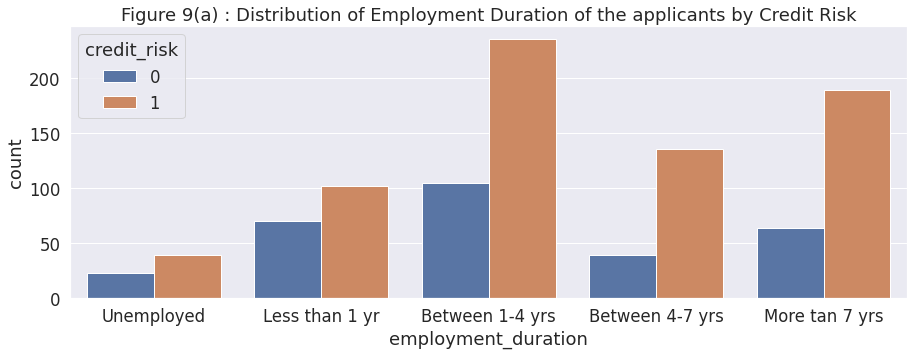

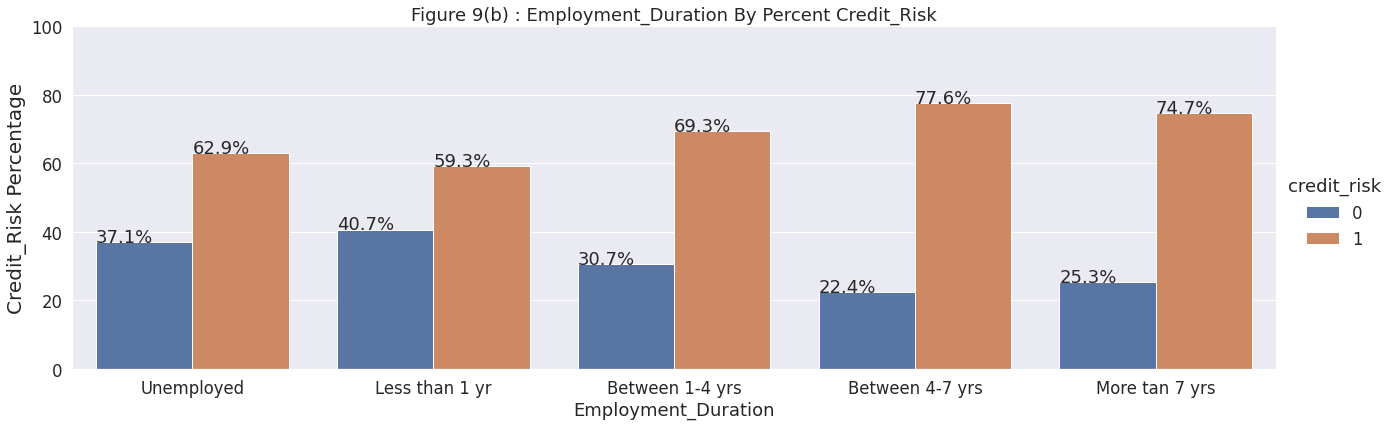

In [42]:
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='employment_duration', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 9(a) : Distribution of Employment Duration of the applicants by Credit Risk')
plt.savefig('/content/Graphs/9_a.jpeg')
plt.show()

plotting_percentages(df, 'employment_duration', 'credit_risk', 9, x_labels)

**OBSERVATIONS :**
- Maority of the credit applicants have their employment duration either between 1-4 yrs or more than 7 yrs
- When categorized based on credit_risk value, both the categories are in almost equal proportion across all the employment_duration types.
- When we observe the percentage plot, we see that customers wo have employment duration less than 1 yr have the highest percentage risk and those wit more than 4 yrs of employment have the lowest risk. This migt be attributed to the fact that customers who have more work experience earn more and hence have less chances of defaulting or not repaying compared to customers with least work experience.

It might be safe to assume that employment_duration might be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**
H0 : 'employment_duration' has no significant effect on 'credit_risk'
H1 : 'employment_duration' has a significant effect on 'credit_risk'

In [41]:
chisq_test(df, 'employment_duration')

<IPython.core.display.Javascript object>

P-Value : 0.0010454523491402541
' employment_duration ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'employment_duration' can be taken as a good predictor for our model.

### **Credit installments as a percentage of debtor's disposable income : 'installment_rate'**



In [43]:
df['installment_rate'].unique()

<IPython.core.display.Javascript object>

array([4, 2, 3, 1])

As per codetable.txt,
- 1 : >= 35         
- 2 : 25 <= ... < 35
- 3 : 20 <= ... < 25
- 4 : < 20  

In [44]:
x_labels = ['Greater than 35%', '25% to 35%', '20% to 25%', 'Less than 20%']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

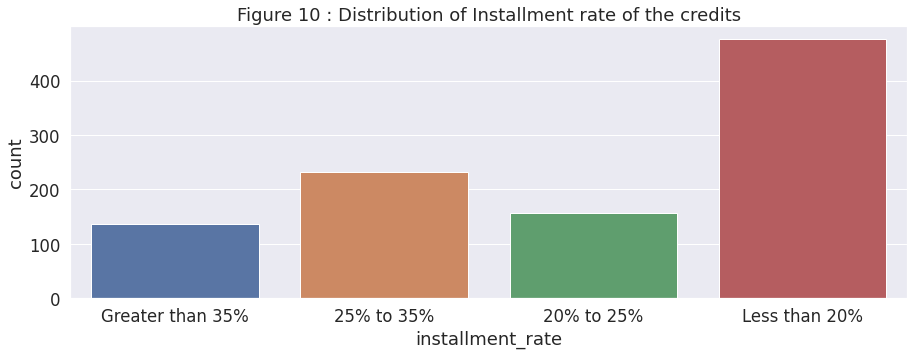

In [45]:
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='installment_rate', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 10 : Distribution of Installment rate of the credits')
plt.savefig('/content/Graphs/10.jpeg')
plt.show()

<IPython.core.display.Javascript object>

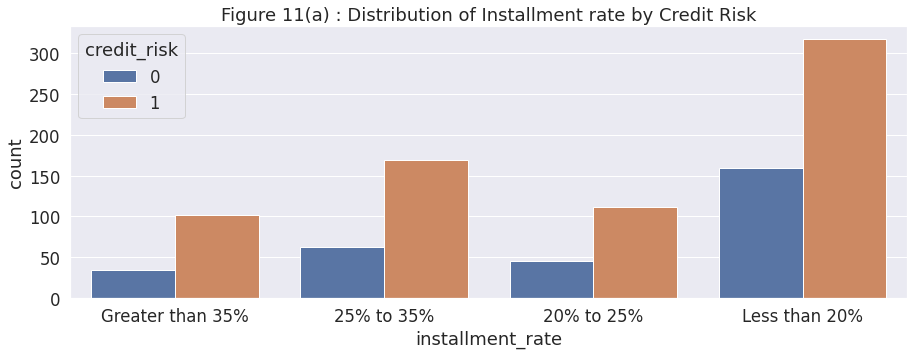

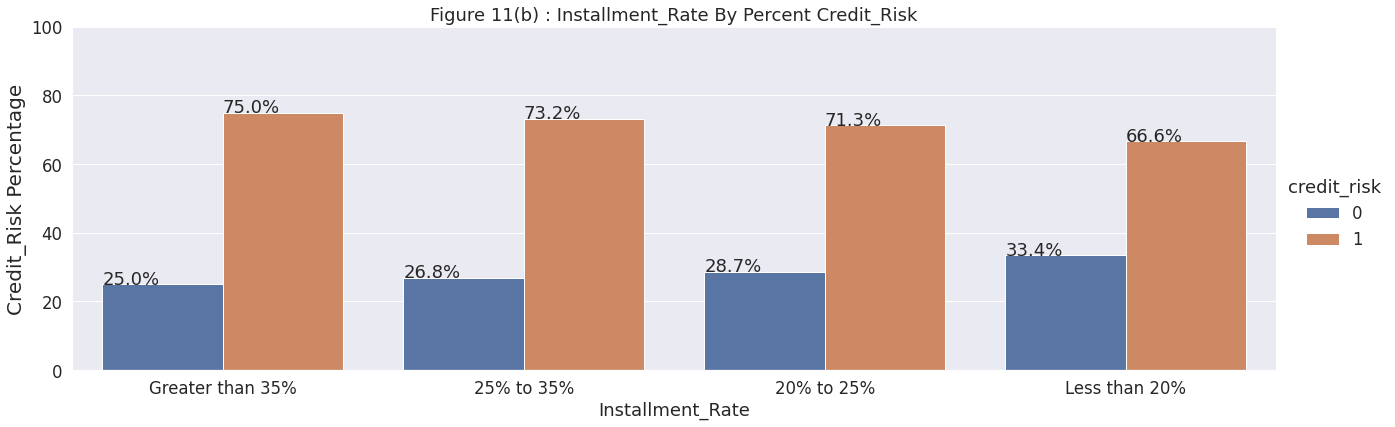

In [46]:
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='installment_rate', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 11(a) : Distribution of Installment rate by Credit Risk')
plt.savefig('/content/Graphs/11_a.jpeg')
plt.show()

plotting_percentages(df, 'installment_rate', 'credit_risk', 11, x_labels)

**OBSERVATIONS :**
- Maority of the credits have installment rates below 20%.
- When categorized based on credit_risk value (count and percentage plots), both the categories are in almost equal proportion(or percentages) across all the installment rate categories.

So, it might be safe to assume that installment_rate might not be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'installment_rate' has no significant effect on 'credit_risk'

H1 : 'installment_rate' has a significant effect on 'credit_risk'

In [47]:
chisq_test(df, 'installment_rate')

<IPython.core.display.Javascript object>

P-Value : 0.1400333122128481
'installment_rate' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'installment_rate' is not a good predictor for our model, and could be dropped.

### **Length of time (in years) the debtor lives in the present residence : 'present_residence'**


In [48]:
# Unique catgorical values for present_residence
df['present_residence'].unique()

<IPython.core.display.Javascript object>

array([4, 2, 3, 1])

As per codetable.txt,
- 1 : < 1 yr          
- 2 : 1 <= ... < 4 yrs
- 3 : 4 <= ... < 7 yrs
- 4 : >= 7 yrs  

In [49]:
# Labels for the categories
x_labels = ['Less than one year', '1 to 4 yrs', '4 to 7 yrs', 'Greater than 7 yrs']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

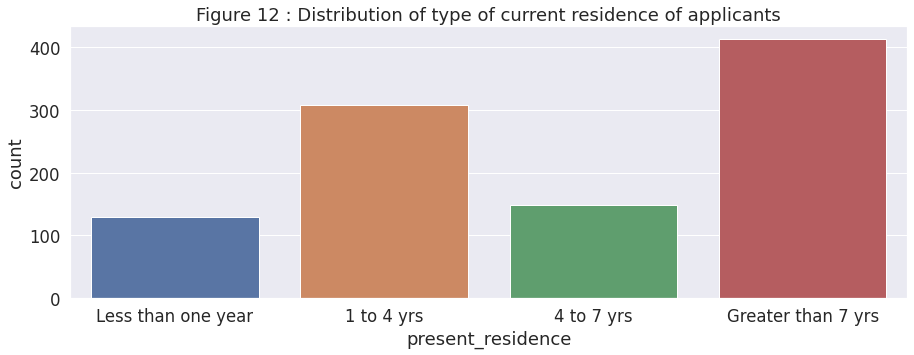

In [50]:
# Plotting the distribution of current residence types
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='present_residence', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 12 : Distribution of type of current residence of applicants')
plt.savefig('/content/Graphs/12.jpeg')
plt.show()

<IPython.core.display.Javascript object>

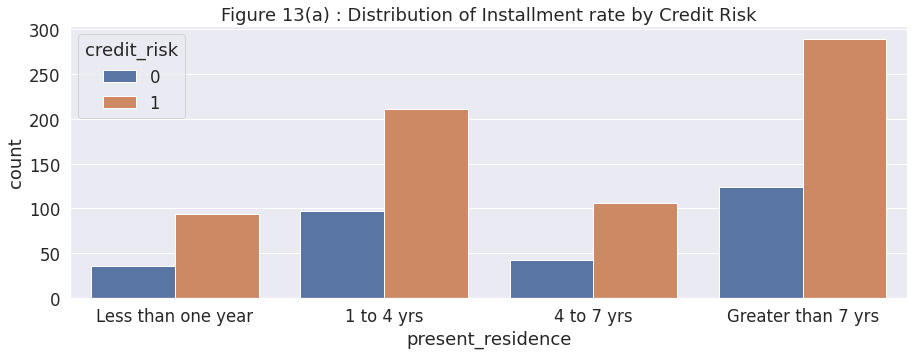

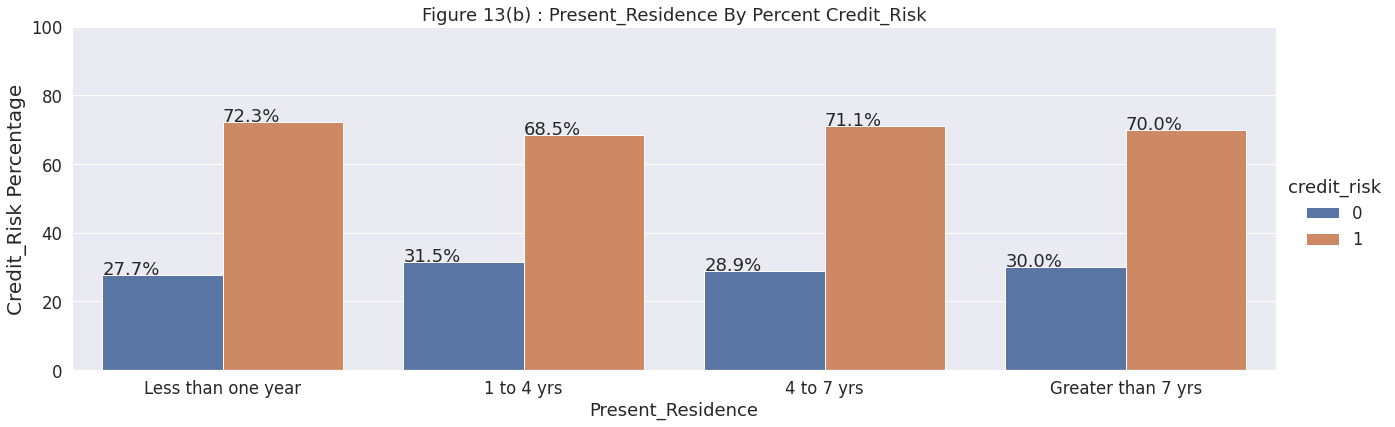

In [51]:
# Plotting distribution of current resident types against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='present_residence', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 13(a) : Distribution of Installment rate by Credit Risk')
plt.savefig('/content/Graphs/13_a.jpeg')
plt.show()

# Percentage plot: present_residence against credit_risk
plotting_percentages(df, 'present_residence', 'credit_risk', 13, x_labels)

**OBSERVATIONS :**
- Maority of the credits have installment rates below 20%.
- When categorized based on credit_risk value (count and percentage plots), both the categories are in almost equal proportion(or percentages) across all the installment rate categories.

So, it might be safe to assume that installment_rate might not be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'installment_rate' has no significant effect on 'credit_risk'

H1 : 'installment_rate' has a significant effect on 'credit_risk'

In [52]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'present_residence')

<IPython.core.display.Javascript object>

P-Value : 0.8615521320413175
'present_residence' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'installment_rate' is not a good predictor for our model, and could be dropped.

### **Debtor's most valuable property : 'property'**


In [53]:
# Unique catgorical values for properties
df['property'].unique()

<IPython.core.display.Javascript object>

array([2, 1, 3, 4])

As per codetable.txt and data description,
- 1 : unknown / no property                    
- 2 : car or other                             
- 3 : building soc. savings agr./life insurance
- 4 : real estate

The highest possible code will be used here. Code 2 is used, if codes 3 or 4 are not applicable (ie, if the debtor does not own a building/savings/insurance or real estate) and there is a car or any other relevant property that does not fall under variable savings

In [54]:
# Labels for the categories
x_labels = ['Unknown/No property', 'Car or other', 'Building/savings/insurance', 'Real estate']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

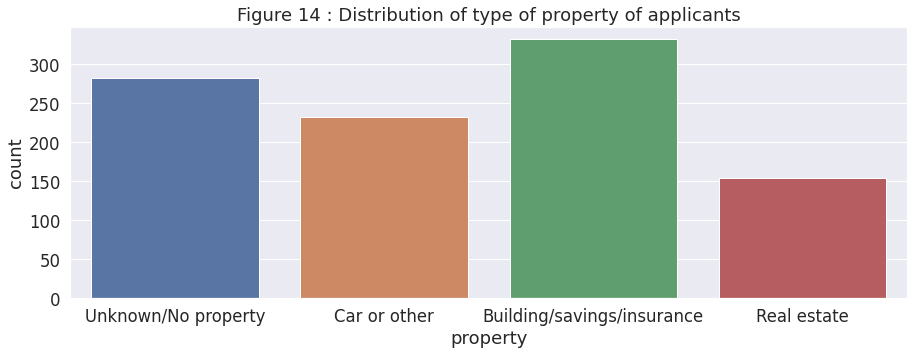

In [55]:
# Plotting the distribution of property types
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='property', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 14 : Distribution of type of property of applicants')
plt.savefig('/content/Graphs/14.jpeg')
plt.show()

<IPython.core.display.Javascript object>

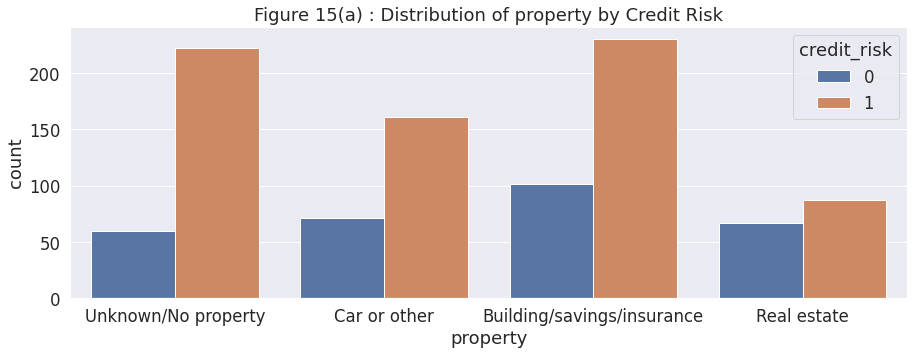

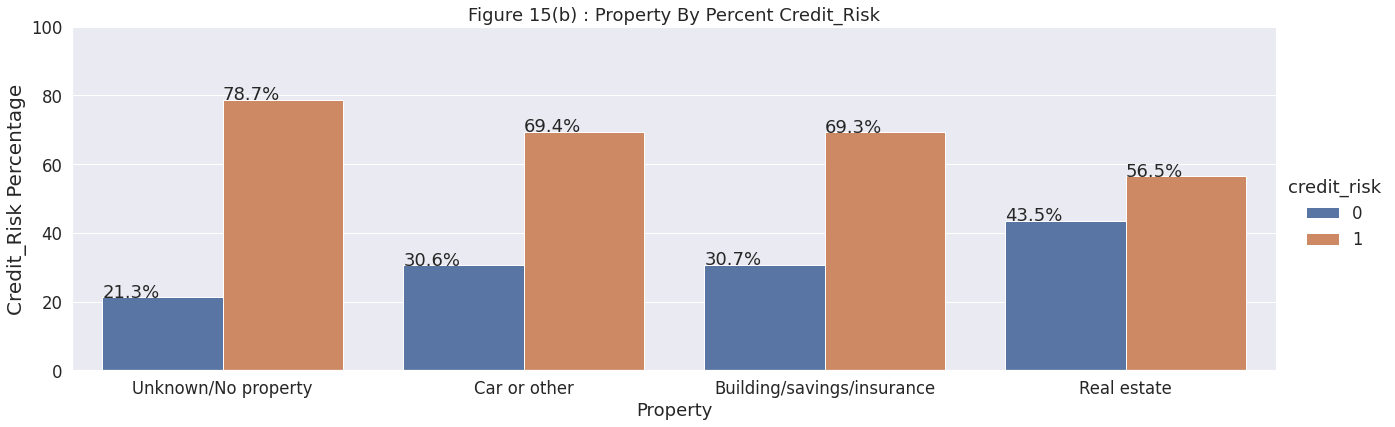

In [56]:
# Plotting distribution of property types against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='property', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 15(a) : Distribution of property by Credit Risk')
plt.savefig('/content/Graphs/15_a.jpeg')
plt.show()

# Percentage plot: present_residence against credit_risk
plotting_percentages(df, 'property', 'credit_risk', 15, x_labels)

**OBSERVATIONS :**
- Most of the debtors have their own building(house)/savings/insurance. And less number of debtors have real estates.
- When categorized based on credit_risk value (count and percentage plots), we see that people who have real estates are the most risk prone group of people compared to other property holders. This might be attributed to the fact that, generally, huge real estates are owned by wealthy people(businessmen, people working in higher positions etc) and as such their purpose for a credit/debt must also need huge amounts, which might cause huge interest rates and chances of repayment delays or skipping repayments are more.
- It is also interesting to note that customers ho do not own much property, seem to be the least risky group of customers when it comes to credits.

So, it might be safe to assume that 'property' might be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'property' has no significant effect on 'credit_risk'

H1 : 'property' has a significant effect on 'credit_risk'

In [57]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'property')

<IPython.core.display.Javascript object>

P-Value : 2.8584415733250017e-05
' property ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'property' is a good predictor for our model.

### **Debtor's job : 'job'**


In [58]:
# Unique catgorical values for properties
df['job'].unique()

<IPython.core.display.Javascript object>

array([3, 2, 1, 4])

As per codetable.txt,
- 1 : unemployed/unskilled - non-resident       
- 2 : unskilled - resident                      
- 3 : skilled employee/official                 
- 4 : manager/self-empl./highly qualif. employee

In [59]:
# Labels for the categories
x_labels = ['Unskilled-non-resident', 'Unskilled-resident', 'skilled/official', 'Manager/self-employed/ \n Highly qualified']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

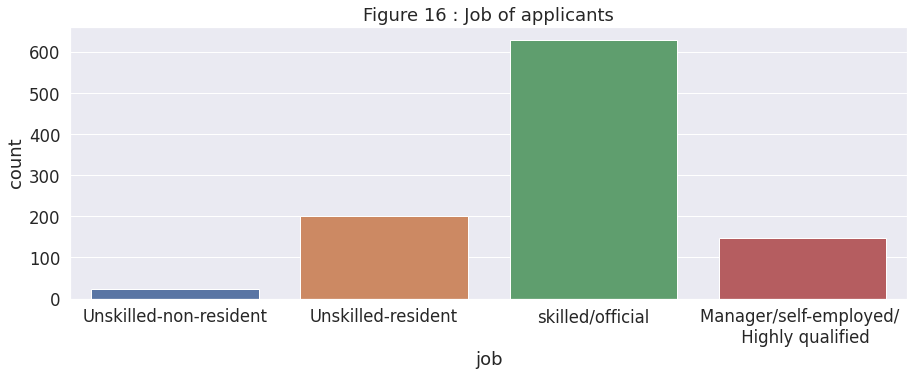

In [60]:
# Plotting the distribution of property types
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='job', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 16 : Job of applicants')
plt.savefig('/content/Graphs/16.jpeg')
plt.show()

<IPython.core.display.Javascript object>

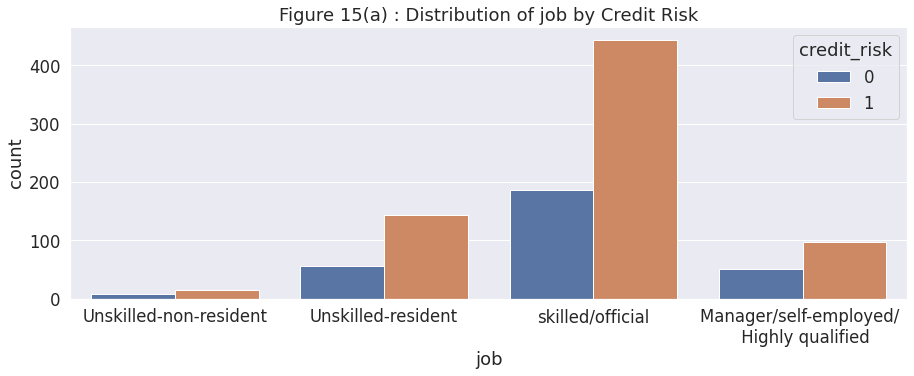

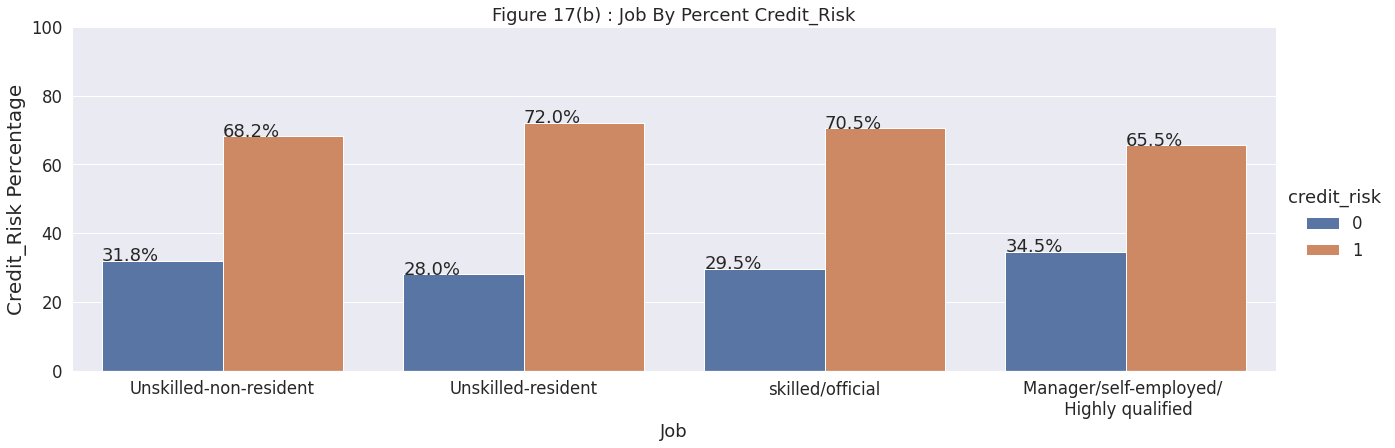

In [61]:
# Plotting distribution of job types against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='job', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 15(a) : Distribution of job by Credit Risk')
plt.savefig('/content/Graphs/17_a.jpeg')
plt.show()

# Percentage plot: present_residence against credit_risk
plotting_percentages(df, 'job', 'credit_risk', 17, x_labels)

**OBSERVATIONS :**
- Most of the debtors are skilled workers/working in office. 
- When categorized based on credit_risk value (count and percentage plots), the proportion of debtors for good and bad risk category are more or less the same/close by across all job types.

So, it might be safe to assume that 'property' is not a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'job' has no significant effect on 'credit_risk'

H1 : 'job' has a significant effect on 'credit_risk'

In [62]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'job')

<IPython.core.display.Javascript object>

P-Value : 0.5965815918843431
'job' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'job' is a not good predictor for our model and could be dropped.

### **Number of credits including the current one the debtor has (or had) at this bank : 'number_credits'**


In [63]:
# Unique catgorical values
df['number_credits'].unique()

<IPython.core.display.Javascript object>

array([1, 2, 3, 4])

As per codetable.txt,
- 1 : 1   
- 2 : 2-3 
- 3 : 4-5 
- 4 : >= 6

In [64]:
# Labels for the categories
x_labels = ['1', '2 to 3', '4 to 5', 'Greater than 6']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

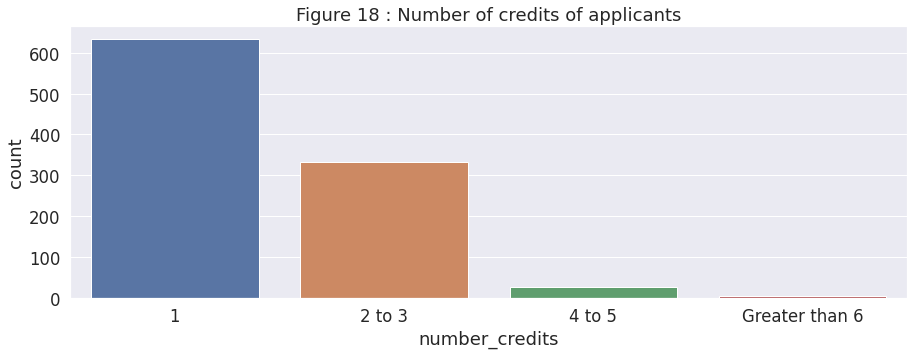

In [65]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='number_credits', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 18 : Number of credits of applicants')
plt.savefig('/content/Graphs/18.jpeg')
plt.show()

<IPython.core.display.Javascript object>

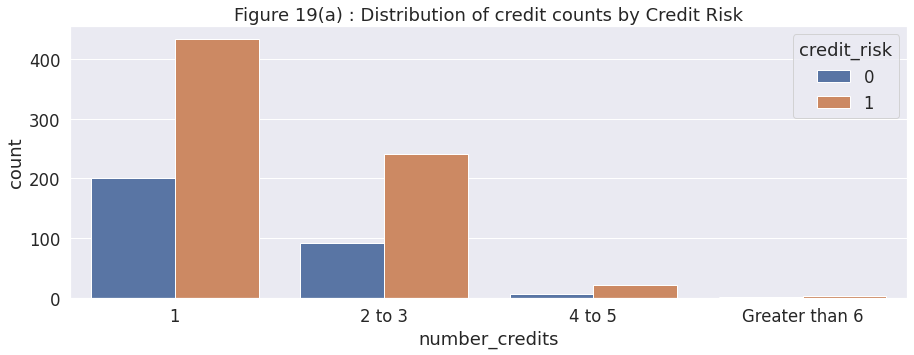

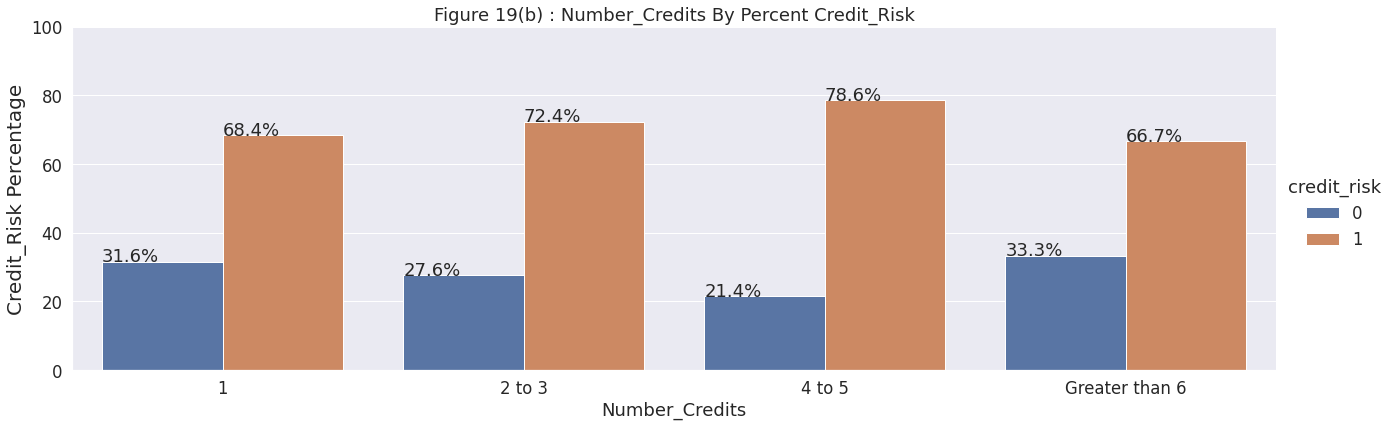

In [68]:
# Plotting distribution of credit counts against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='number_credits', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 19(a) : Distribution of credit counts by Credit Risk')
plt.savefig('/content/Graphs/19_a.jpeg')
plt.show()

# Percentage plot: present_residence against credit_risk
plotting_percentages(df, 'number_credits', 'credit_risk', 19, x_labels)

**OBSERVATIONS :**
- Most of the debtors have only 1 credit/loans wit this bank. 
- When categorized based on credit_risk value (count and percentage plots), the proportion of debtors for good and bad risk category are more or less the same/close by across all number_credit categories.

So, it might be safe to assume that 'number_credits' is not a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'number_credits' has no significant effect on 'credit_risk'

H1 : 'number_credits' has a significant effect on 'credit_risk'

In [67]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'number_credits')

<IPython.core.display.Javascript object>

P-Value : 0.4451440800083001
'number_credits' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'number_credits' is a not good predictor for our model and could be dropped.

### **Status of the debtor's checking account with the bank : 'status'**


In [69]:
# Unique catgorical values
df['status'].unique()

<IPython.core.display.Javascript object>

array([1, 2, 4, 3])

As per codetable.txt,
- 1 : no checking account                       
- 2 : ... < 0 DM                                
- 3 : 0<= ... < 200 DM                          
- 4 : ... >= 200 DM / salary for at least 1 year


In [70]:
# Labels for the categories
x_labels = ['No checking account', 'Less than 0 DM', '0 to 200 DM', 'Greater than 200DM or \n Salary for min 1 yr']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

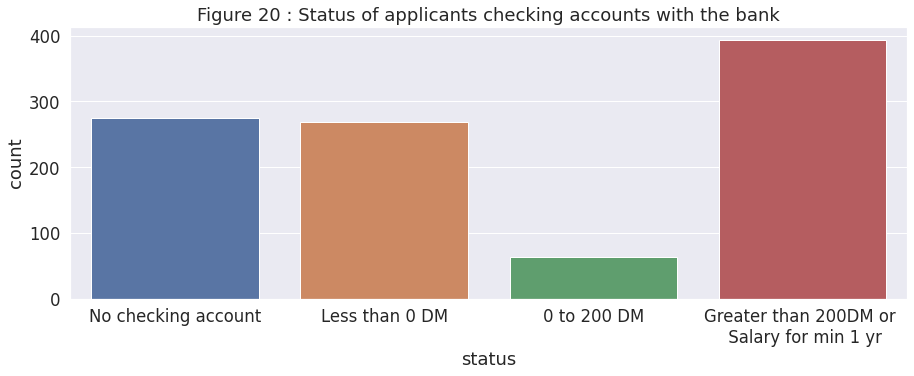

In [71]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='status', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 20 : Status of applicants checking accounts with the bank')
plt.savefig('/content/Graphs/20.jpeg')
plt.show()

<IPython.core.display.Javascript object>

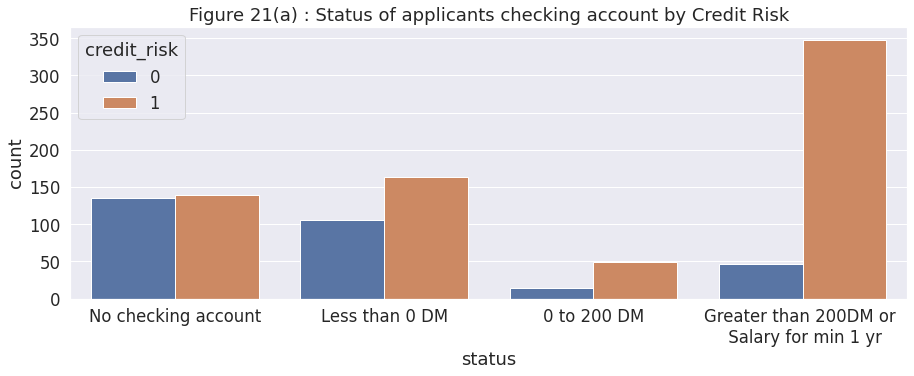

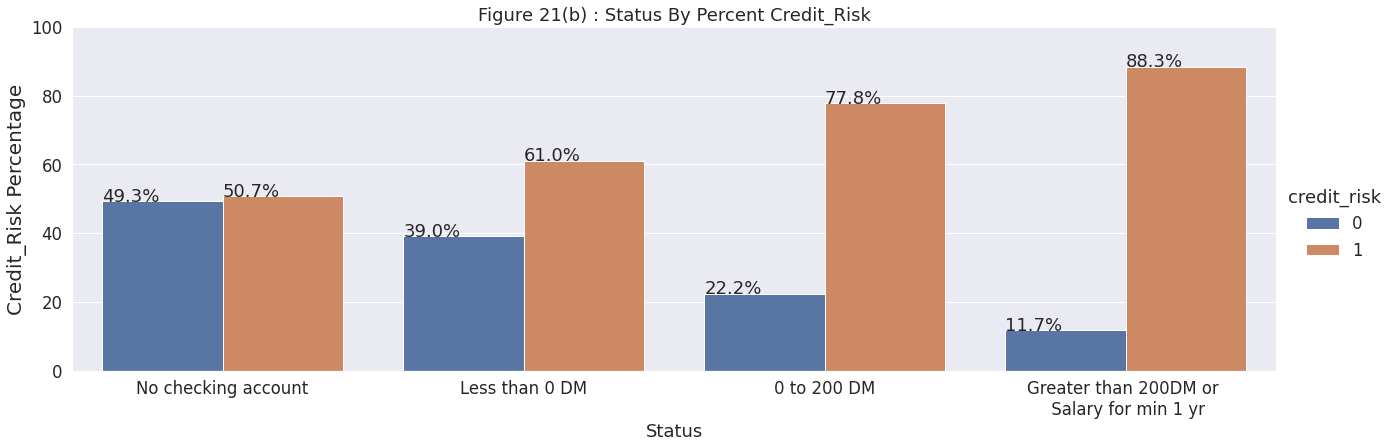

In [72]:
# Plotting distribution of applicants' checking account against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='status', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 21(a) : Status of applicants checking account by Credit Risk')
plt.savefig('/content/Graphs/21_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'status', 'credit_risk', 21, x_labels)

**OBSERVATIONS :**
- Majority of the applicants have greater than 200DM / 1yr salary in their account.
- When categorized based on credit_risk value ( percentage plot), applicants who have no checking account with the bank have the highest bad-risk(0) percentage and decreases with the increase in the amount in the checking account (refer fig 21(b)).

So, it might be safe to assume that 'status' is a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'status' has no significant effect on 'credit_risk'

H1 : 'status' has a significant effect on 'credit_risk'

In [73]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'status')

<IPython.core.display.Javascript object>

P-Value : 1.2189020722893755e-26
' status ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** Our assumption is proved to be true; 'status' is infact a good predictor for our model, statistically.

### **History of compliance with previous or concurrent credit contracts : 'credit_history'**


In [74]:
# Unique catgorical values
df['credit_history'].unique()

<IPython.core.display.Javascript object>

array([4, 2, 3, 0, 1])

As per codetable.txt,
- 0 : delay in paying off in the past            
- 1 : critical account/other credits elsewhere   
- 2 : no credits taken/all credits paid back duly
- 3 : existing credits paid back duly till now   
- 4 : all credits at this bank paid back duly    



In [75]:
# Labels for the categories
x_labels = ['Delay in paying off \n in the past', 'Critical account/ \n other credits elsewhere', 
            'No credits taken/ \n all credits paid back duly', 'Existing credits paid \n back duly till now',
            'All credits at this \n bank paid back duly']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

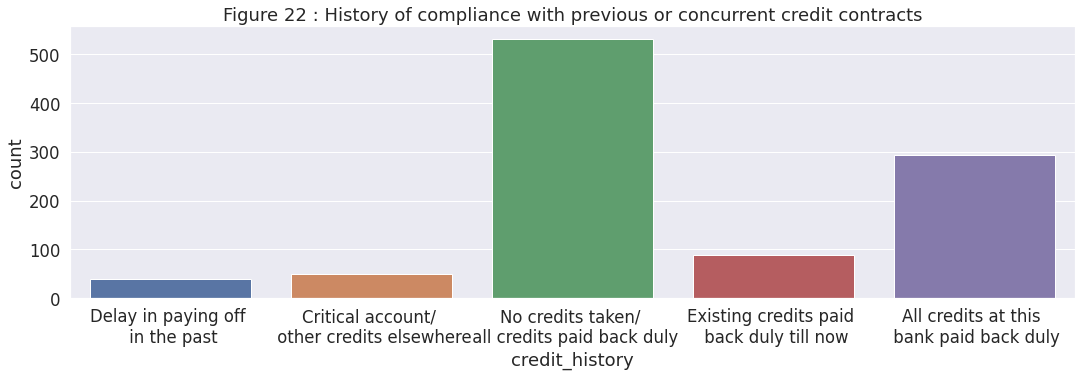

In [76]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='credit_history', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 22 : History of compliance with previous or concurrent credit contracts')
plt.savefig('/content/Graphs/22.jpeg')
plt.show()

<IPython.core.display.Javascript object>

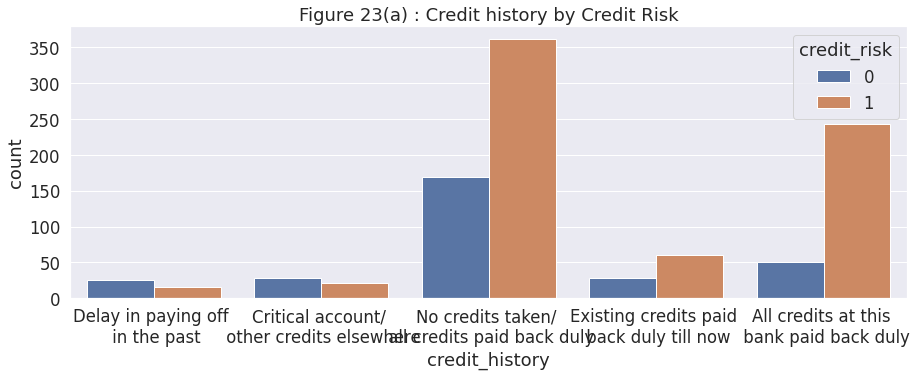

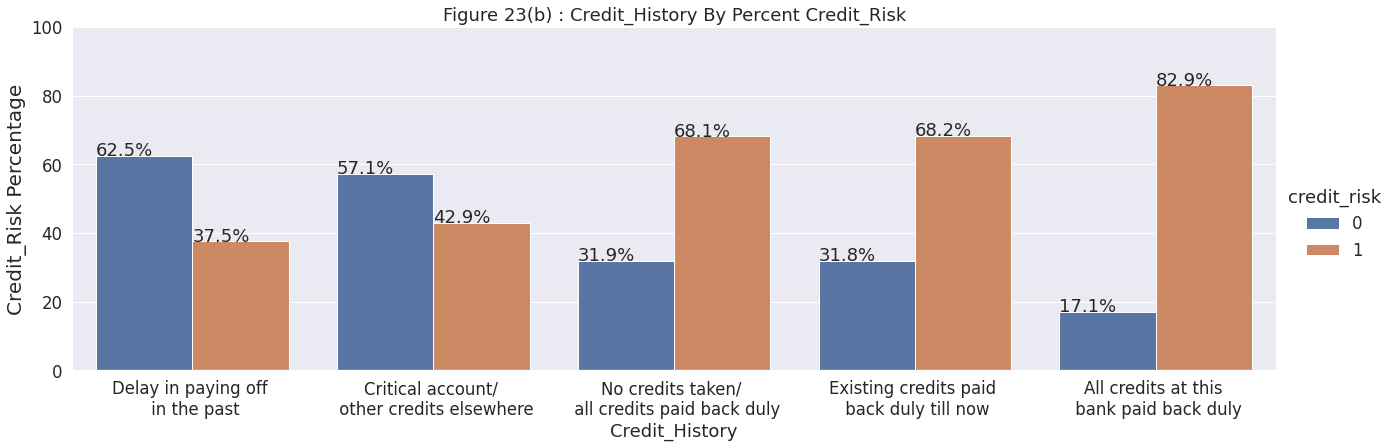

In [77]:
# Plotting distribution of applicants' checking account against credit_risk
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.countplot(x='credit_history', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 23(a) : Credit history by Credit Risk')
plt.savefig('/content/Graphs/23_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'credit_history', 'credit_risk', 23, x_labels)

**OBSERVATIONS :**
- Majority of the applicants have no credits taken or all their credits have been paid back duly.
- When categorized based on credit_risk value ( percentage plot), applicants who have delayed in repaying in the past, have the highest bad-risk(0) percentage and least with the customers who have paid all credits at this bank, duly (refer fig 23(b)).

We shall assume that 'credit_history' is a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'credit_history' has no significant effect on 'credit_risk'

H1 : 'credit_history' has a significant effect on 'credit_risk'

In [78]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'credit_history')

<IPython.core.display.Javascript object>

P-Value : 1.2791872956750918e-12
' credit_history ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** Our assumption is proved to be true; 'credit_history' is infact a good predictor for our model, statistically.

### **Purpose for which the credit is needed : 'purpose'**


In [79]:
# Unique catgorical values
df['purpose'].unique()

<IPython.core.display.Javascript object>

array([ 2,  0,  9,  3,  1, 10,  5,  4,  6,  8])

In [80]:
df['purpose'].value_counts()

<IPython.core.display.Javascript object>

3     280
0     234
2     181
1     103
9      97
6      50
5      22
10     12
4      12
8       9
Name: purpose, dtype: int64

As per codetable.txt,
-  0 : others             
-  1 : car (new)          
-  2 : car (used)         
-  3 : furniture/equipment
-  4 : radio/television   
-  5 : domestic appliances
-  6 : repairs            
-  7 : education          
-  8 : vacation           
-  9 : retraining         
-  10 : business  


In [81]:
# Labels for the categories
x_labels = ['Others', 'Car(New)', 'Car(Used)', 'Furniture/ \n Equipment', 'Radio/ \n television', 'Domestic \n appliances',
            'Repairs', 'Vacation', 'Retraining', 'Business']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

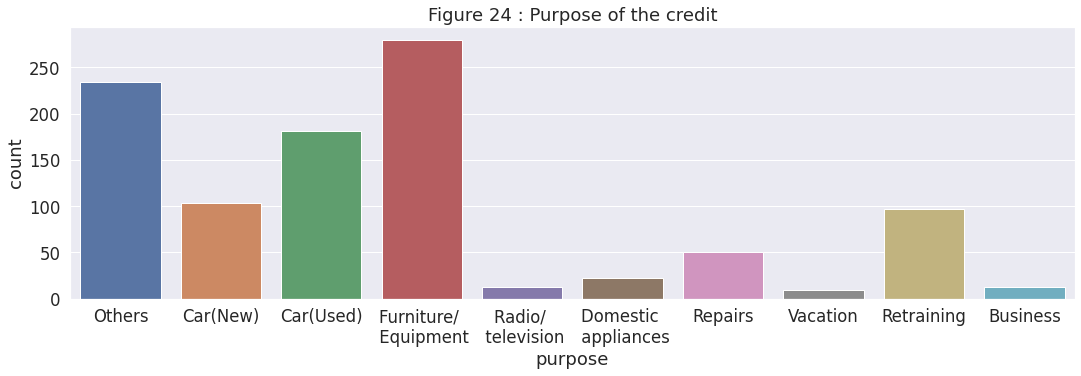

In [82]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='purpose', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 24 : Purpose of the credit')
plt.savefig('/content/Graphs/24.jpeg')
plt.show()

<IPython.core.display.Javascript object>

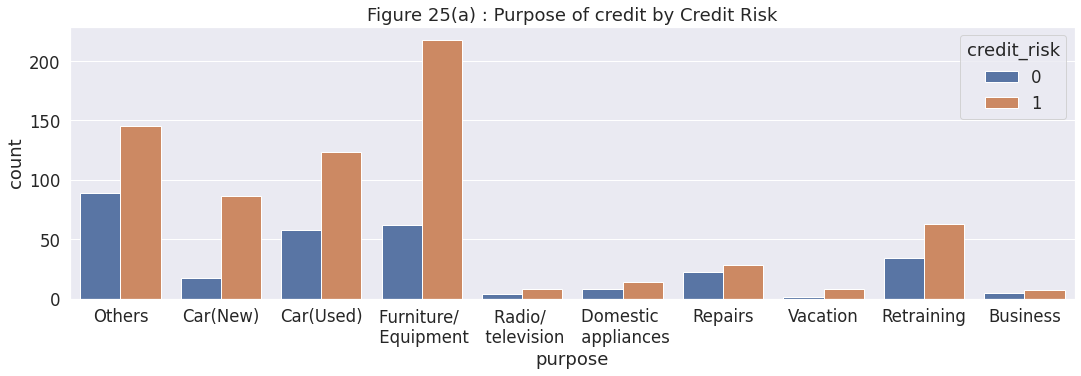

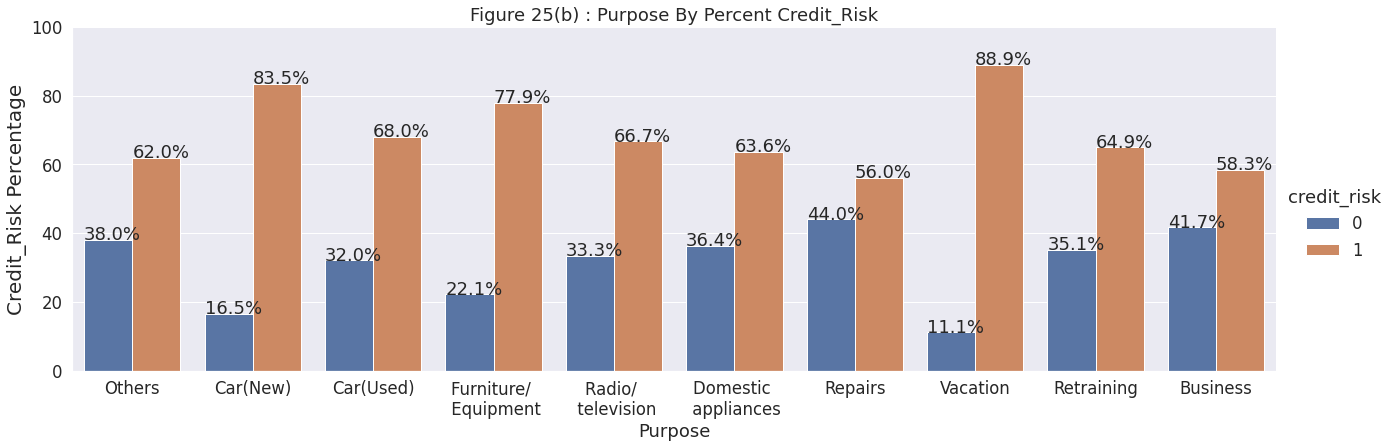

In [83]:
# Plotting distribution of applicants' checking account against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='purpose', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 25(a) : Purpose of credit by Credit Risk')
plt.savefig('/content/Graphs/25_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'purpose', 'credit_risk', 25, x_labels)

**OBSERVATIONS :**
- Most of the credit applicants have applied for credit loans for the purpose of furnishing, buying used cars, and other general purposes.
- When categorized based on credit_risk value ( percentage plot), aplicants who have applied for business, repair puposes, have been marked as highest bad-risk(0) percentage and least with the customers who have mentioned their purpose as Vacation, probably because the amount applied for might be small and can be quickly repaid. (refer fig 23(b)).

Since there is a difference in the risk percentage for each purpose category, we are bound to assume that 'purpose' might be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'purpose' has no significant effect on 'credit_risk'

H1 : 'purpose' has a significant effect on 'credit_risk'

In [84]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'purpose')

<IPython.core.display.Javascript object>

P-Value : 0.00011574910079691586
' purpose ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** Our assumption is proved to be true; 'purpose' is infact a good predictor for our model, statistically.

### **Debtor's savings : 'savings'**


In [85]:
# Unique catgorical values
df['savings'].unique()

<IPython.core.display.Javascript object>

array([1, 2, 3, 5, 4])

In [86]:
df['savings'].value_counts()

<IPython.core.display.Javascript object>

1    603
5    183
2    103
3     63
4     48
Name: savings, dtype: int64

As per codetable.txt,
-  1 : unknown/no savings account
-  2 : ... <  100 DM             
-  3 : 100 <= ... <  500 DM      
-  4 : 500 <= ... < 1000 DM      
-  5 : ... >= 1000 DM  


In [87]:
# Labels for the categories
x_labels = ['Unknown/ \n No savings', 'Less than 100DM', '100DM to 500DM', '500DM to 1000DM', 'Greater than 1000DM']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

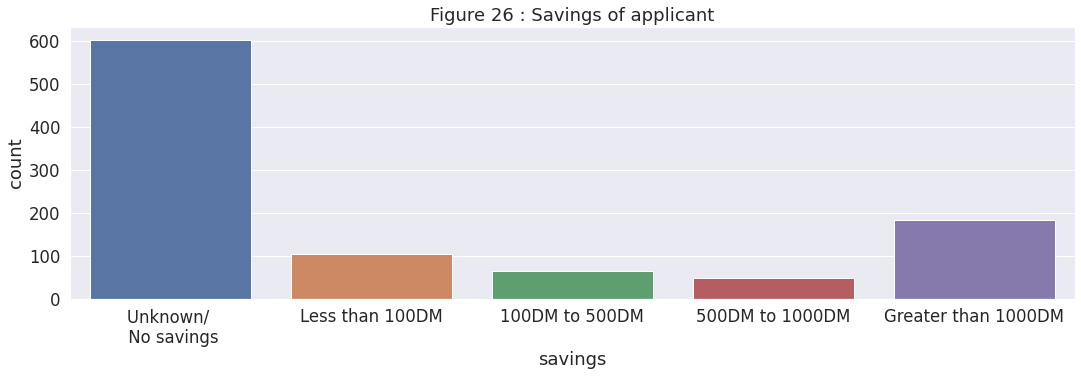

In [88]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='savings', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 26 : Savings of applicant')
plt.savefig('/content/Graphs/26.jpeg')
plt.show()

<IPython.core.display.Javascript object>

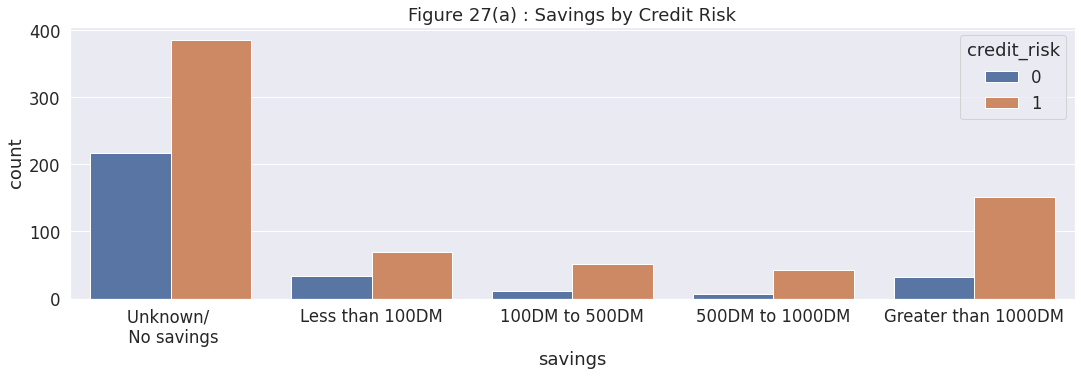

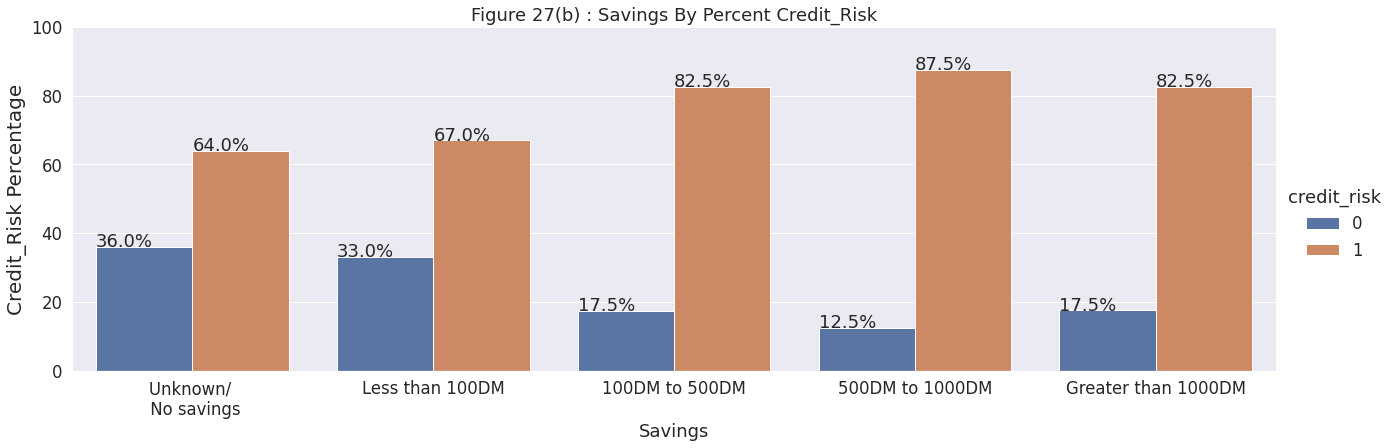

In [89]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='savings', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 27(a) : Savings by Credit Risk')
plt.savefig('/content/Graphs/27_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'savings', 'credit_risk', 27, x_labels)

**OBSERVATIONS :**
- Huge % of the credit applicants have either have no savings in the bank or might have savings unknown to the bank.
- Aplicants who have unknown/no savings with the bank, have been marked as highest bad-risk(0) percentage and least with the applicants who have 500-1000 DM. But in general we see the the bad risk percentage decreases with increase in savings(refer fig 23(b)).

And so, we shall assume that 'savings' might be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'savings' has no significant effect on 'credit_risk'

H1 : 'savings' has a significant effect on 'credit_risk'

In [90]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'savings')

<IPython.core.display.Javascript object>

P-Value : 2.761214238568249e-07
' savings ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** Our assumption is proved to be true; 'savings' is infact a good predictor for our model, statistically.

### **Information on sex and marital status : 'personal_status_sex'**


In [ ]:
# Unique catgorical values
df['personal_status_sex'].unique()

array([2, 3, 4, 1])

In [ ]:
df['personal_status_sex'].value_counts()

3    548
2    310
4     92
1     50
Name: personal_status_sex, dtype: int64

As per codetable.txt,
- 1 : male : divorced/separated           
- 2 : female : non-single or male : single
- 3 : male : married/widowed              
- 4 : female : single 


In [ ]:
# Labels for the categories
x_labels = ['Male \n divorced/separated', 'Female Non-single / \n Male Single', 'Male \n Married/Widowed', 'Female \n Single']

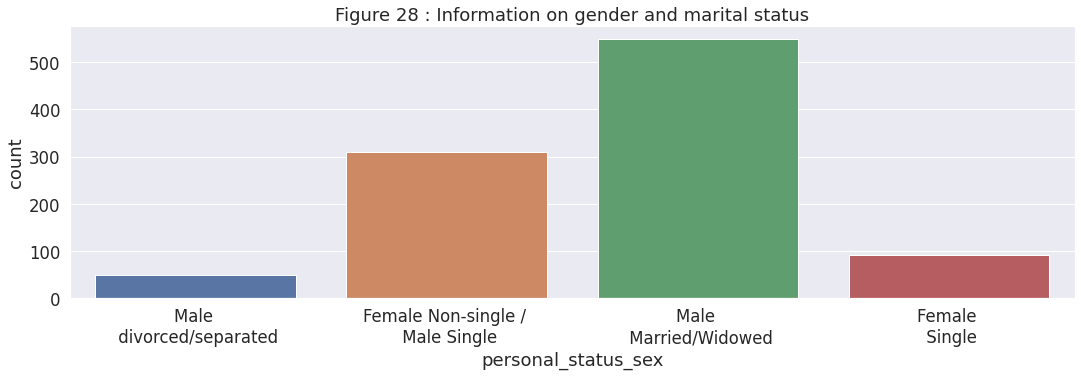

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='personal_status_sex', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 28 : Information on gender and marital status')
plt.savefig('/content/Graphs/28.jpeg')
plt.show()

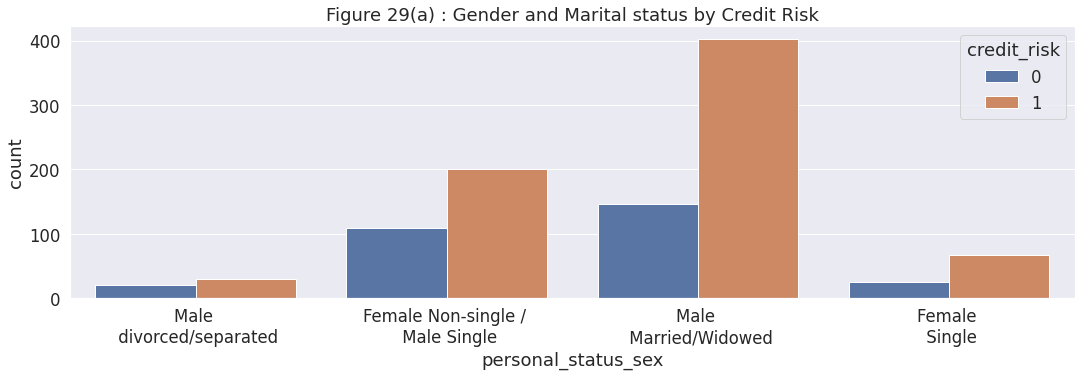

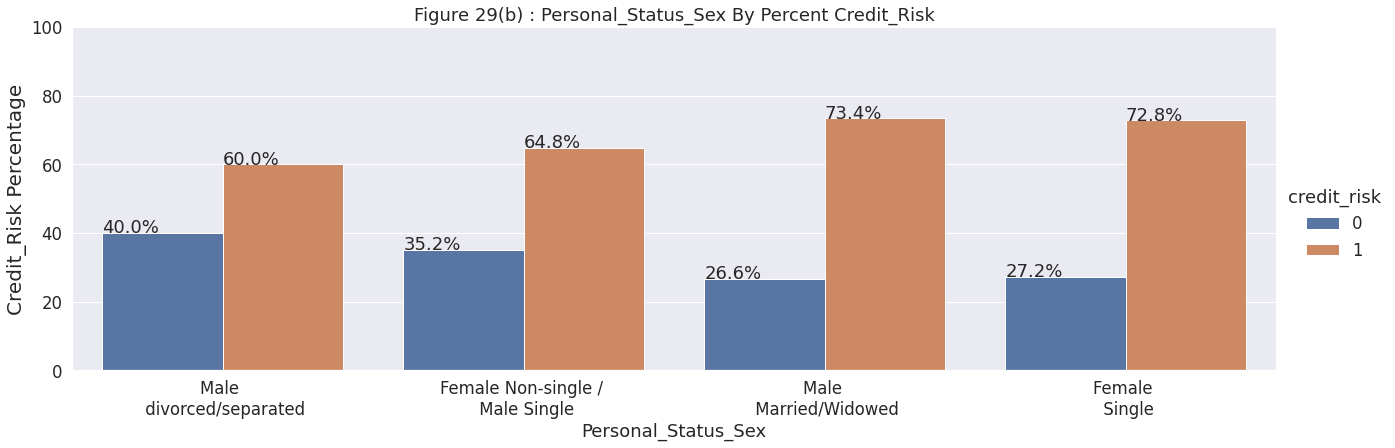

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='personal_status_sex', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 29(a) : Gender and Marital status by Credit Risk')
plt.savefig('/content/Graphs/29_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'personal_status_sex', 'credit_risk', 29, x_labels)

**OBSERVATIONS :**
- Majority of the applicants belong to the group Male:married/widowed and least number of Male:separated/divorced.
- Aplicants who are Male:divorced/separated have been marked as highest bad-risk(0) percentage(refer fig 23(b)). But overall, there does not seem to be any particular pattern among the gender-marital status categories.

Lets assume that 'peronal_status_sex' is not a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'personal_status_sex' has no significant effect on 'credit_risk'

H1 : 'personal_status_sex' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'personal_status_sex')

P-Value : 0.02223800546926877
' personal_status_sex ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** Our assumption is proved to be wrong; 'personal_status_sex' is infact a good predictor for our model, statistically.

### **Possibility of another debtor or a guarantor for the credit : 'other_debtors'**


In [ ]:
# Unique catgorical values
df['other_debtors'].unique()

array([1, 3, 2])

In [ ]:
df['other_debtors'].value_counts()

1    907
3     52
2     41
Name: other_debtors, dtype: int64

As per codetable.txt,
- 1 : none
- 2 : co-applicant
- 3 : guarantor

In [ ]:
# Labels for the categories
x_labels = ['None', 'Co-applicant', 'Guarantor']

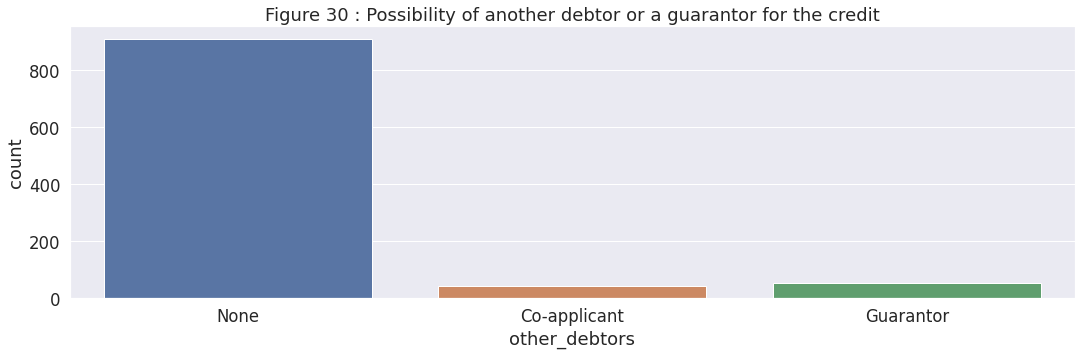

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='other_debtors', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 30 : Possibility of another debtor or a guarantor for the credit')
plt.savefig('/content/Graphs/30.jpeg')
plt.show()

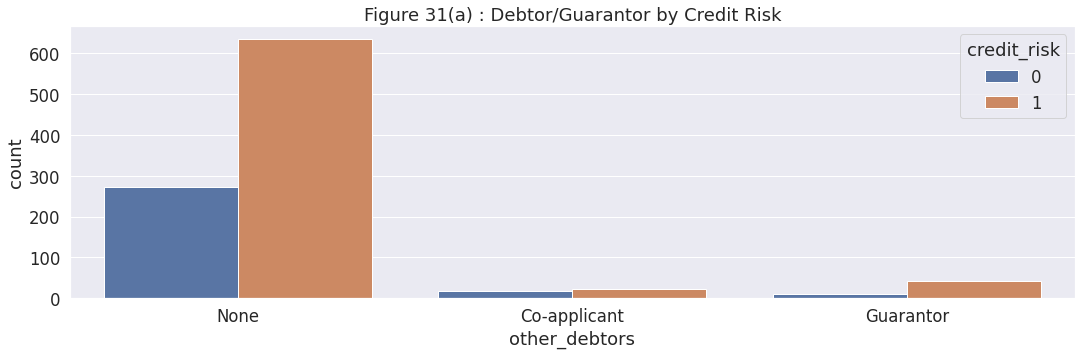

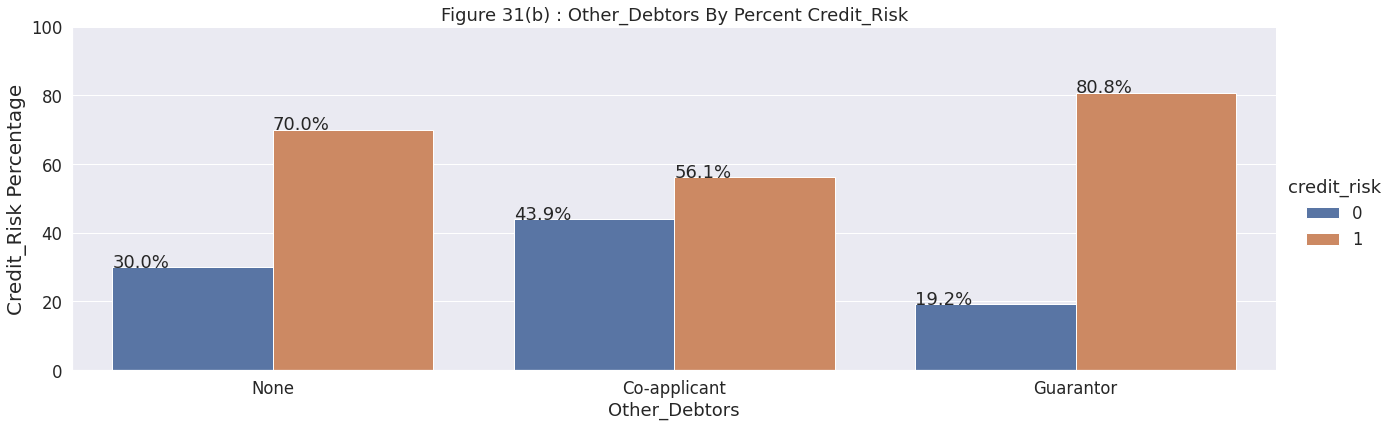

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='other_debtors', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 31(a) : Debtor/Guarantor by Credit Risk')
plt.savefig('/content/Graphs/31_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'other_debtors', 'credit_risk', 31, x_labels)

**OBSERVATIONS :**
- 90 percent of the applicants do not have any kind of co-debtors or guarantors.
- Surprisingly, the chances of an applicant with a co-applicant/co-debtor belonging to credit risk category 0(bad risk), is shown to be more, compared to other groups.

Lets see if this variable proves to be a good predictor variable for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'other_debtors' has no significant effect on 'credit_risk'

H1 : 'other_debtors' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'other_debtors')

P-Value : 0.036055954027247206
' other_debtors ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'other_debtors' is a good predictor for our model, statistically.

### **Installment plans from providers other than the credit-giving bank : 'other_installment_plans'**


In [ ]:
# Unique catgorical values
df['other_installment_plans'].unique()

array([3, 1, 2])

In [ ]:
df['other_installment_plans'].value_counts()

3    814
1    139
2     47
Name: other_installment_plans, dtype: int64

As per codetable.txt,
- 1 : bank  
- 2 : stores
- 3 : none 

In [ ]:
# Labels for the categories
x_labels = ['Bank', 'Stores', 'None']

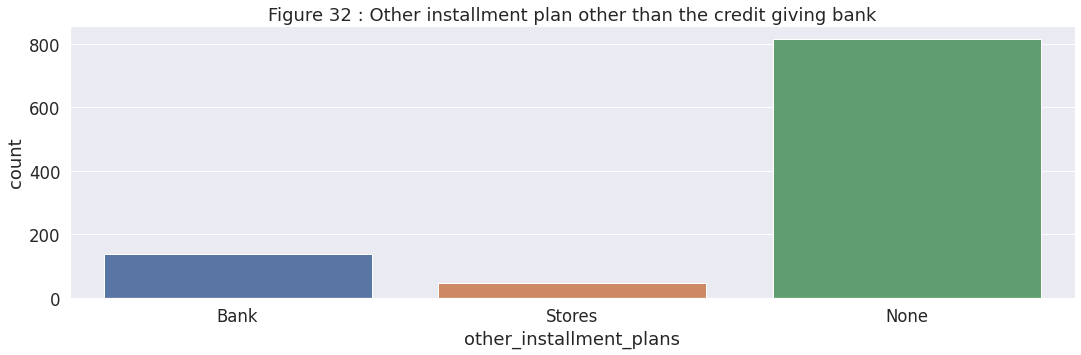

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='other_installment_plans', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 32 : Other installment plan other than the credit giving bank')
plt.savefig('/content/Graphs/32.jpeg')
plt.show()

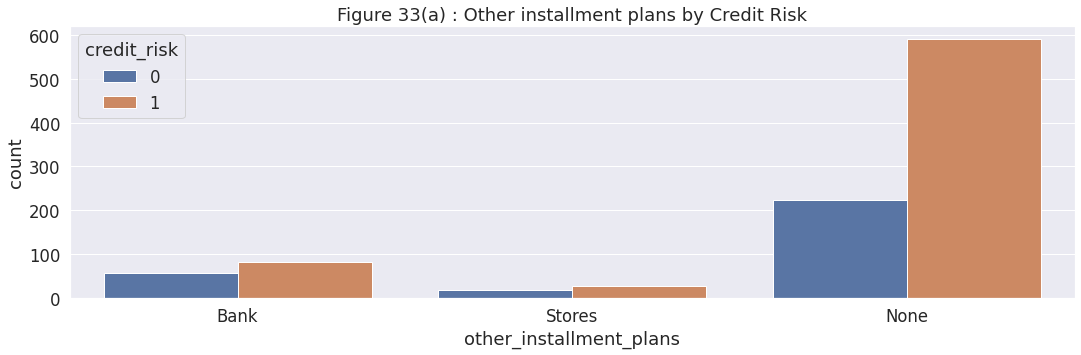

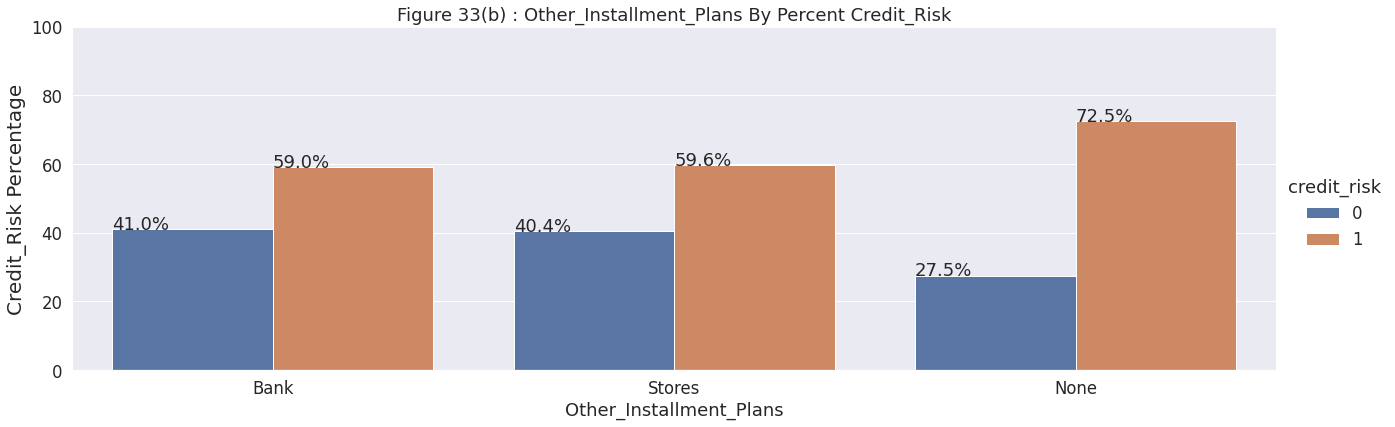

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='other_installment_plans', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 33(a) : Other installment plans by Credit Risk')
plt.savefig('/content/Graphs/33_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'other_installment_plans', 'credit_risk', 33, x_labels)

**OBSERVATIONS :**
- 80 percent of the applicants do not have any other installment plans elsewhere.
- Applicants who do have other installment plans in other places have more chances to be classified into bad risk(0).

Since, there is a visible and understandable relation between other_install_ment_lan with credit_risk, we shall assume that it is a good predictor for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'other_installment_plans' has no significant effect on 'credit_risk'

H1 : 'other_installment_plans' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'other_installment_plans')

P-Value : 0.0016293178186473534
' other_installment_plans ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'other_installment_plans' is a good predictor for our model, statistically.

### **Type of housing : 'housing'**


In [ ]:
# Unique catgorical values
df['housing'].unique()

array([1, 2, 3])

In [ ]:
df['housing'].value_counts()

2    714
1    179
3    107
Name: housing, dtype: int64

As per codetable.txt,
- 1 : free housing 
- 2 : rented
- 3 : own 

In [ ]:
# Labels for the categories
x_labels = ['Free housing', 'Rented', 'Own']

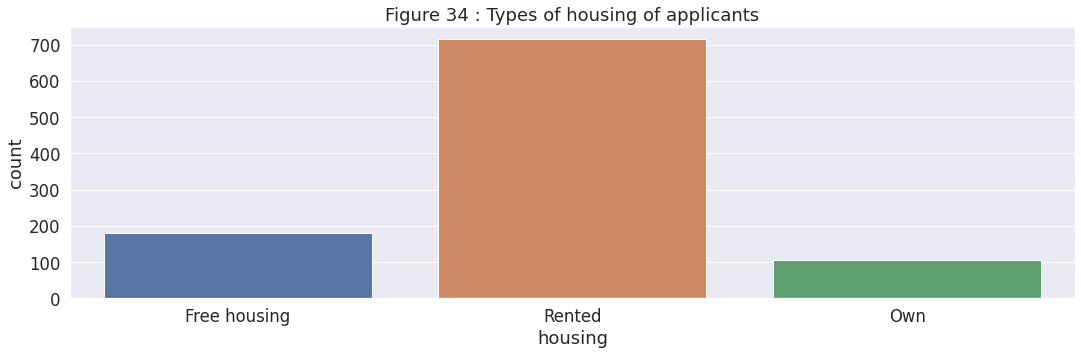

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='housing', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 34 : Types of housing of applicants')
plt.savefig('/content/Graphs/34.jpeg')
plt.show()

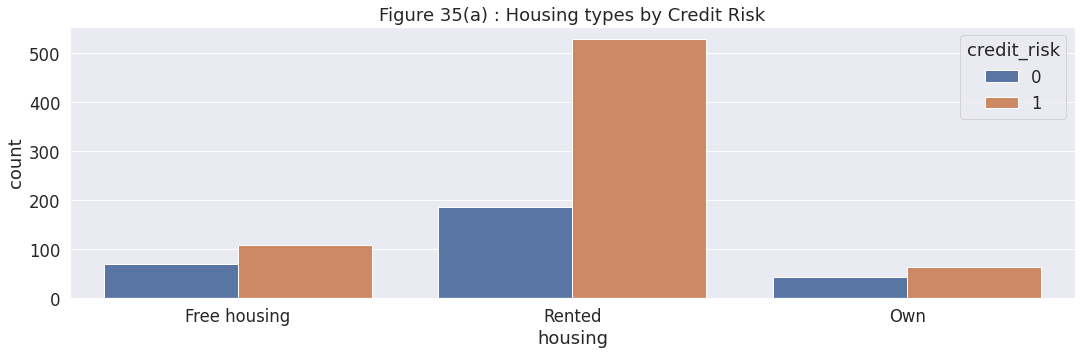

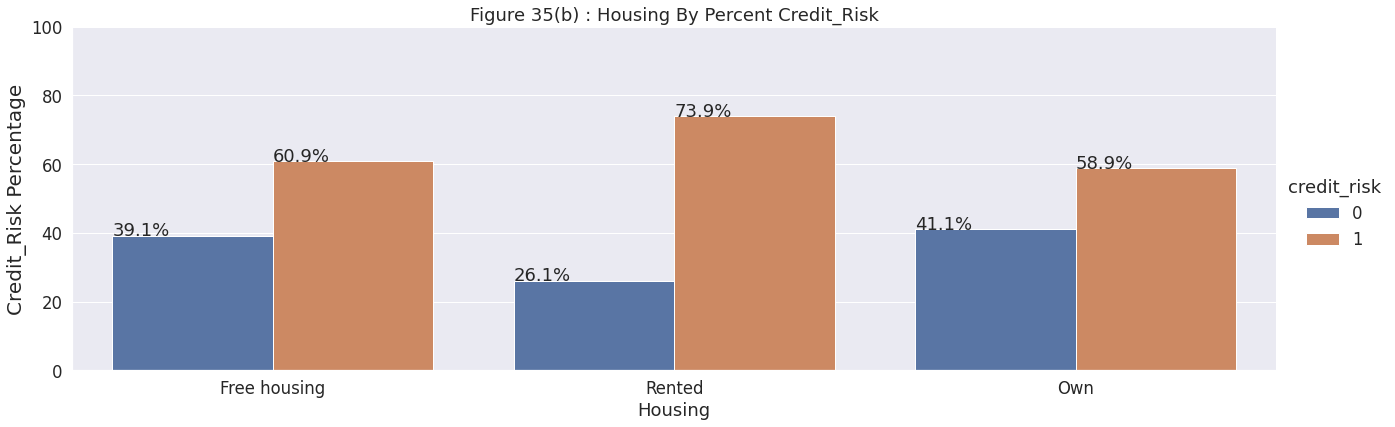

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='housing', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 35(a) : Housing types by Credit Risk')
plt.savefig('/content/Graphs/35_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'housing', 'credit_risk', 35, x_labels)

**OBSERVATIONS :**
- 70 percent of the applicants live in rented house/apartments.
- Applicants living in rented houses are less classified into bad risk(0) category, as compared to those living in free and own houses.

So, there seems to be some relation between housing with credit_risk; we shall assume that 'housing' is a good predictor for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'housing' has no significant effect on 'credit_risk'

H1 : 'housing' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'housing')

P-Value : 8.810311250241031e-05
' housing ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'housing' is a good predictor for our model, statistically.

### **Availability of registered telephone numbe : 'telephone'**


In [ ]:
# Unique catgorical values
df['telephone'].unique()

array([1, 2])

In [ ]:
df['telephone'].value_counts()

1    596
2    404
Name: telephone, dtype: int64

As per codetable.txt,
- 1 : No
- 2 : Yes

In [ ]:
# Labels for the categories
x_labels = ['No', 'Yes']

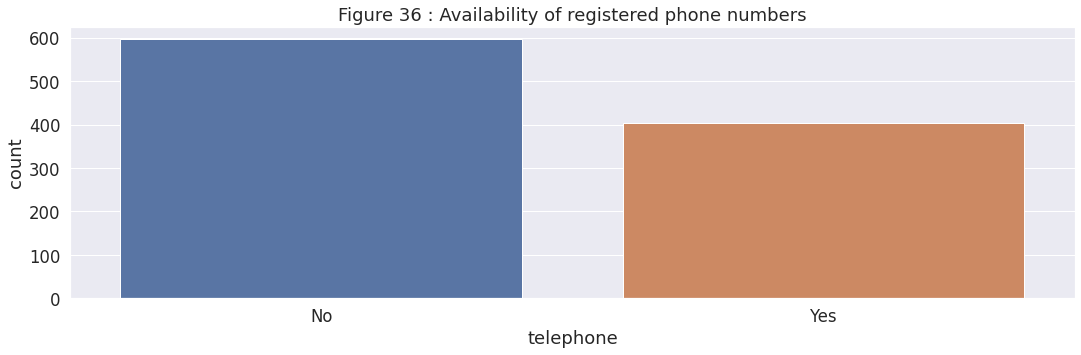

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='telephone', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 36 : Availability of registered phone numbers')
plt.savefig('/content/Graphs/36.jpeg')
plt.show()

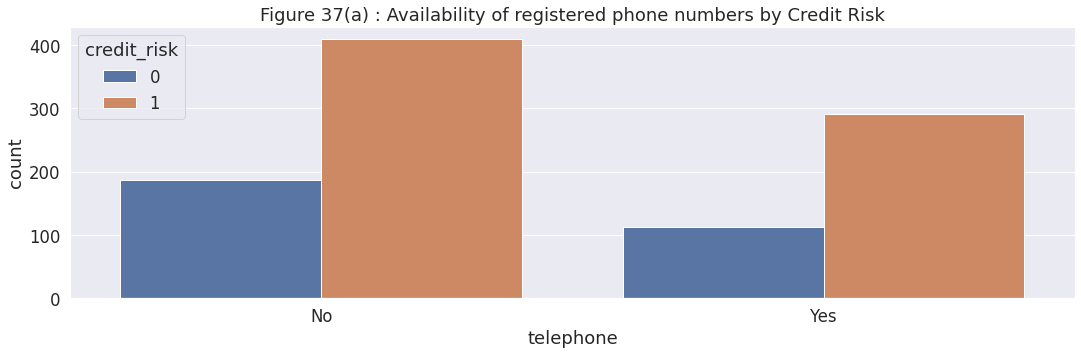

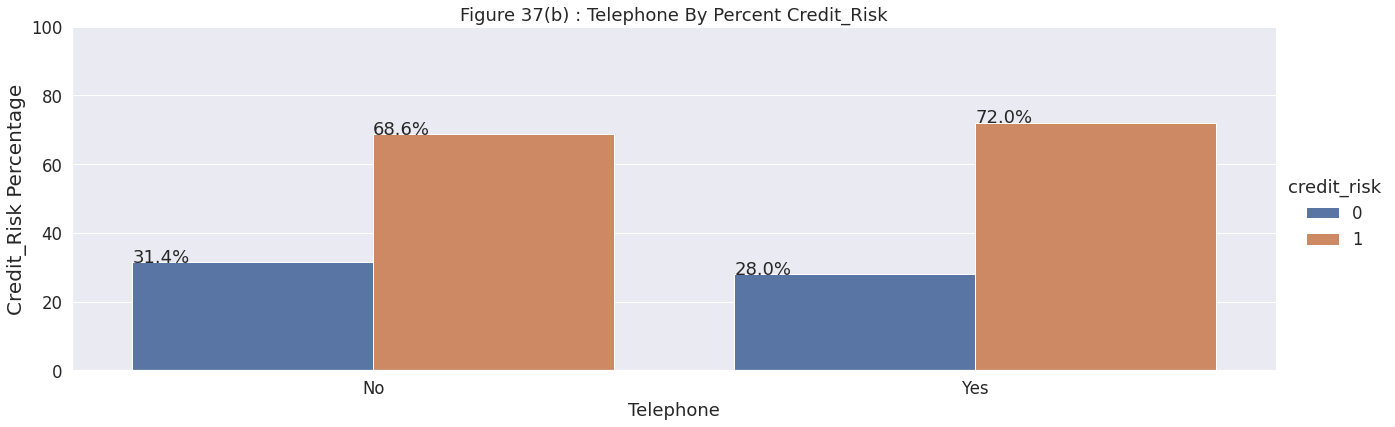

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='telephone', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 37(a) : Availability of registered phone numbers by Credit Risk')
plt.savefig('/content/Graphs/37_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'telephone', 'credit_risk', 37, x_labels)

**OBSERVATIONS :**
- Around 60 percent of the applicants do not have a telephone number registered under their name.
- The percentage of customers classified as bad risk(0), is similar in terms of percentage, ie, around 30% (refer fig 37(b)).

We shall assume that 'telephone' is not a good predictor for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'telephone' has no significant effect on 'credit_risk'

H1 : 'telephone' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'telephone')

P-Value : 0.2788761543035742
'telephone' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'telephone' is therefore not a good predictor for our model, statistically.

### **If the applicant is a foreign worker : 'foreign_worker'**


In [ ]:
# Unique catgorical values
df['foreign_worker'].unique()

array([2, 1])

In [ ]:
df['foreign_worker'].value_counts()

2    963
1     37
Name: foreign_worker, dtype: int64

As per codetable.txt,
- 1 : Yes
- 2 : No

In [ ]:
# Labels for the categories
x_labels = ['Yes', 'No']

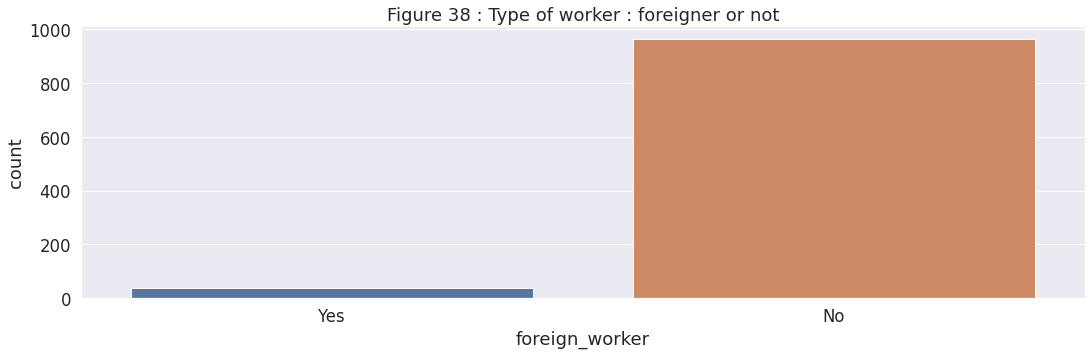

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='foreign_worker', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 38 : Type of worker : foreigner or not')
plt.savefig('/content/Graphs/38.jpeg')
plt.show()

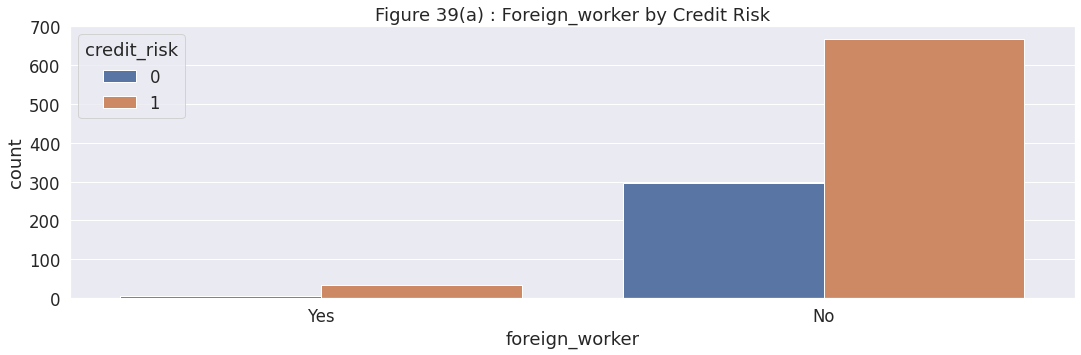

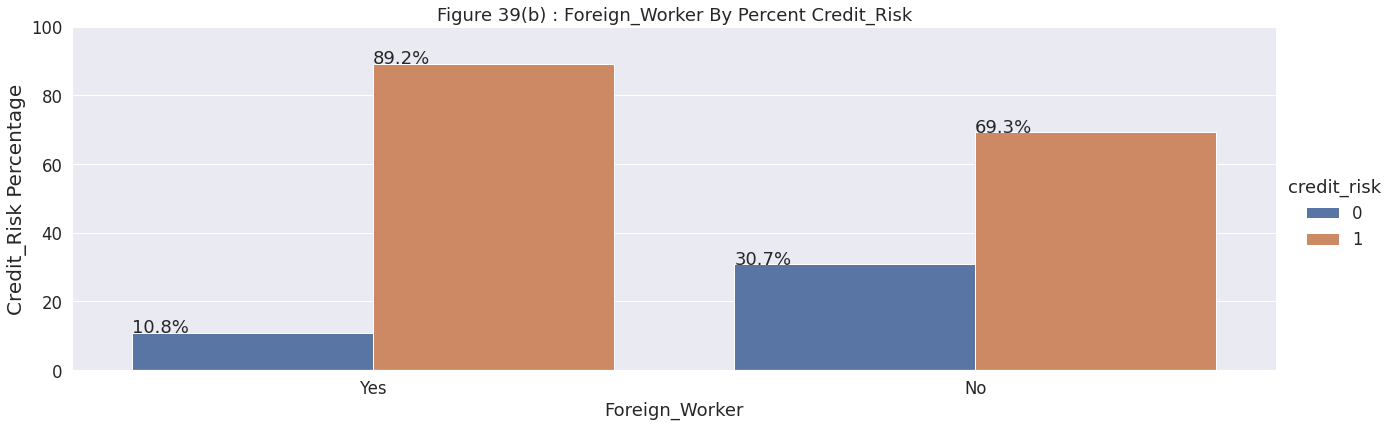

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='foreign_worker', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 39(a) : Foreign_worker by Credit Risk')
plt.savefig('/content/Graphs/39_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'foreign_worker', 'credit_risk', 39, x_labels)

**OBSERVATIONS :**
- 90 percent of the applicants are not foreign workers.
- 30% of these non foreign workers are classified as bad risk(0), while only 10% of the foreign workers are classified as bad risk.

So, clearly there seems to be some relation between foreign_worker with credit_risk; we shall assume that 'foreign_worker' is a good predictor for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'foreign_worker' has no significant effect on 'credit_risk'

H1 : 'foreign_worker' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'foreign_worker')

P-Value : 0.015830754902852885
' foreign_worker ' IS CORRELATED with 'credit_risk'


**CONCLUSION :** 'foreign_worker' is a good predictor for our model, statistically.

### **Number of people dependent on the applicant : 'people_liable'**


In [ ]:
# Unique catgorical values
df['people_liable'].unique()

array([2, 1])

In [ ]:
df['people_liable'].value_counts()

2    845
1    155
Name: people_liable, dtype: int64

As per codetable.txt,
- 1 : 3 or more people
- 2 : 0 to 2 people

In [ ]:
# Labels for the categories
x_labels = ['3 or more', '0 to 2']

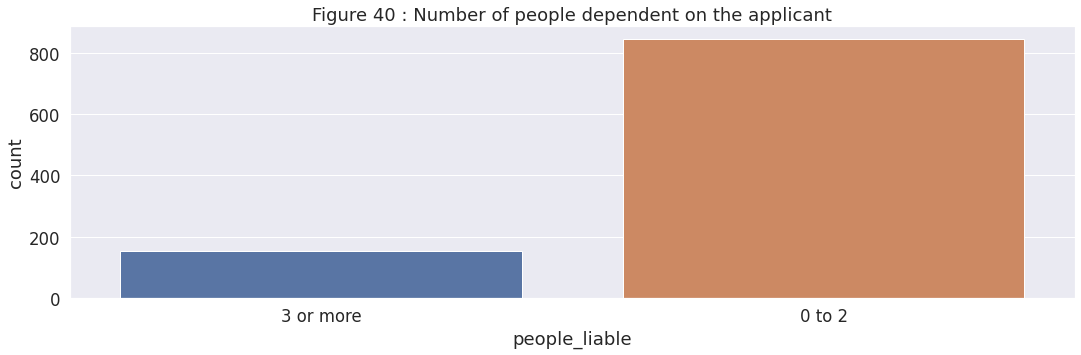

In [ ]:
# Plotting the distribution 
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='people_liable', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 40 : Number of people dependent on the applicant')
plt.savefig('/content/Graphs/40.jpeg')
plt.show()

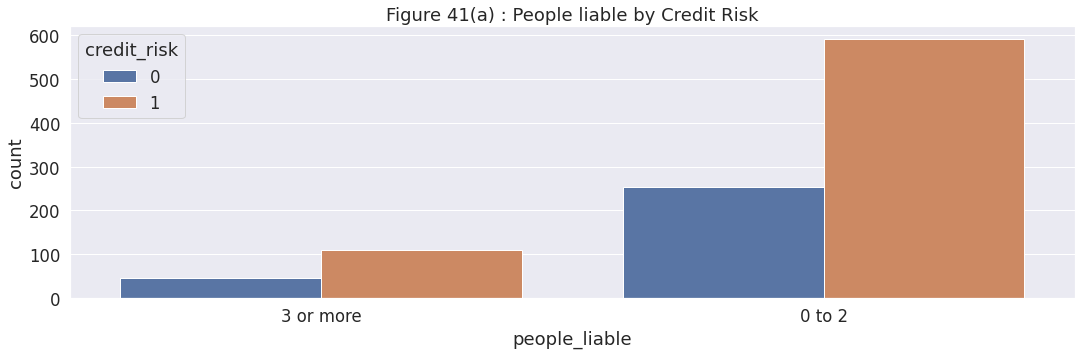

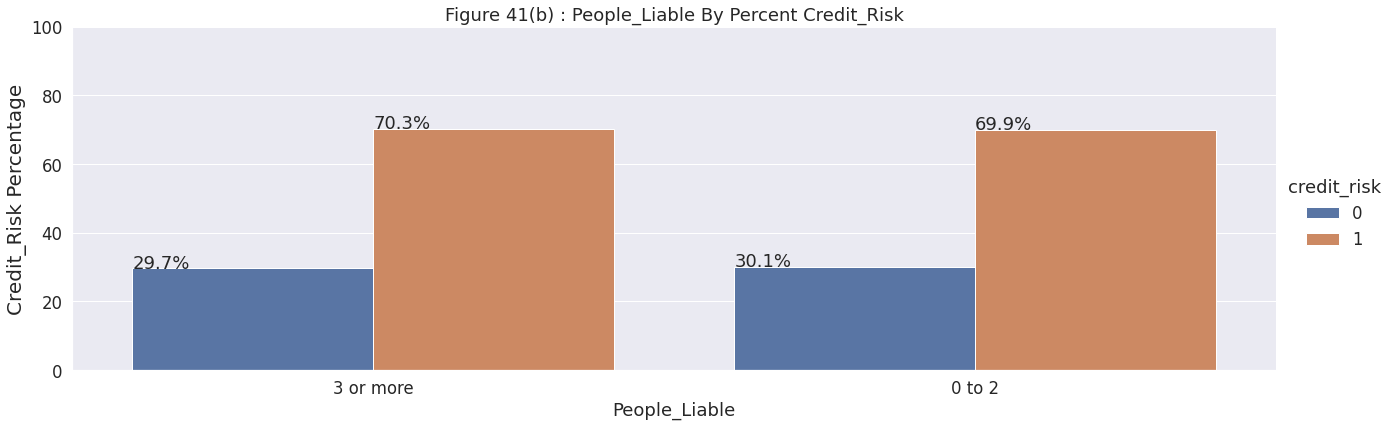

In [ ]:
# Plotting distribution of applicants' savings against credit_risk
fig,ax = plt.subplots(figsize=(18,5))
ax=sns.countplot(x='people_liable', hue='credit_risk', data=df)
ax.set_xticklabels(x_labels)
plt.title('Figure 41(a) : People liable by Credit Risk')
plt.savefig('/content/Graphs/41_a.jpeg')
plt.show()

# Percentage plot: Status of checking account against credit_risk
plotting_percentages(df, 'people_liable', 'credit_risk', 41, x_labels)

**OBSERVATIONS :**
- 85 percent of the applicants have 0-2 other people dependent on them.
- The percent of aplicants classified as bad risk is almost the same for both the categories og people_liable variable

Since, there doesn't seem to any visible relation between housing with credit_risk, we shall assume that 'people_liable' is not a good predictor for our model.

**Hypothesis Test : Chi-Square Test**

H0 : 'people_liable' has no significant effect on 'credit_risk'

H1 : 'people_liable' has a significant effect on 'credit_risk'

In [ ]:
# Statistical test to find the significance of the feature for our model
chisq_test(df, 'people_liable')

P-Value : 1.0
'people_liable' IS NOT CORRELATED with credit_risk


**CONCLUSION :** 'people_liable' is not a good predictor for our model, and can be dropped from our modeling data.

In [ ]:
logger.info('Exploratory Data Analysis completed.')

INFO:root:Exploratory Data Analysis completed.


# **Drop less significant columns**

Based on the statistical tests performed for each predictor variable, we found the following variables to be less significant in predicting the output of or model: telephone, number_credits, job, present_residence, installment_rate and people_liable.

Therefore, we drop the columns fom the dataset and save it for the next stage of our model development.

In [ ]:
logger.info('Dropping less significant variables..')

INFO:root:Dropping less significant variables..


In [ ]:
df.drop(['telephone', 'number_credits', 'job', 'present_residence', 'installment_rate', 'people_liable'],
        axis=1,
        inplace=True)

In [ ]:
df = df[['id', 'status', 'duration', 'credit_history', 'purpose', 'amount', 'savings', 'employment_duration',
         'personal_status_sex', 'other_debtors', 'property', 'age', 'other_installment_plans', 'housing', 'foreign_worker',
         'credit_risk']]
df.head()

,id,status,duration,credit_history,purpose,amount,savings,employment_duration,personal_status_sex,other_debtors,property,age,other_installment_plans,housing,foreign_worker,credit_risk
296,0,1,18,4,2,1049,1,2,2,1,2,21,3,1,2,1
255,1,1,9,4,0,2799,1,3,3,1,1,36,3,1,2,1
312,2,2,12,2,9,841,2,4,2,1,1,23,3,1,2,1
989,3,1,12,4,0,2122,1,3,3,1,1,39,3,1,1,1
339,4,1,12,4,0,2171,1,3,3,1,2,38,1,2,1,1


# **Save data to Cassandra database**

In [ ]:
logger.info('Inserting new data to database..')

INFO:root:Inserting new data to database..


In [ ]:
# Delete table if exists
table_name = 'gcr2'
session.execute("USE {keyspace};".format(keyspace=keyspace))
session.execute("DROP TABLE IF EXISTS {table_name};".format(table_name=table_name))

In [ ]:
# Save the new dataset in Cassandra
# Create new table called 'gcr2'
# Create a table
table_name = 'gcr2'
session.execute("USE {keyspace};".format(keyspace=keyspace))

session.execute(
  "CREATE TABLE {table_name}(ID int PRIMARY KEY, status int, duration int,credit_history int,purpose int,"
  "amount int,savings int,employment_duration int, personal_status_sex int, other_debtors int, property int,"
  "age int, other_installment_plans int, housing int, foreign_worker int, credit_risk int);".format(table_name=table_name))


DEBUG:cassandra.connection:Message pushed from server: <EventMessage(event_type='SCHEMA_CHANGE', event_args={'target_type': 'TABLE', 'change_type': 'CREATED', 'keyspace': 'german_credit', 'table': 'gcr2'}, stream_id=-1, trace_id=None)>
DEBUG:cassandra.cluster:Refreshing schema in response to schema change. {'target_type': 'TABLE', 'change_type': 'CREATED', 'keyspace': 'german_credit', 'table': 'gcr2'}
DEBUG:cassandra.cluster:[control connection] Waiting for schema agreement
DEBUG:cassandra.cluster:[control connection] Schemas match
DEBUG:cassandra.cluster:[control connection] Waiting for schema agreement
DEBUG:cassandra.cluster:[control connection] Schemas match


In [ ]:
# Save the dataset as csv file
df.to_csv('German_credit_2.csv', index=None)

In [ ]:
# Insert data to table 'gc2'
# Insert data into table
file = "/content/German_credit_2.csv"
with open(file, mode='r') as f:
  next(f)

  reader = csv.reader(f)
  for i in reader:

      data = ','.join([value for value in i])
      session.execute("USE {keyspace};".format(keyspace=keyspace))

      session.execute(
         "INSERT INTO {table_name} (ID, status,duration,credit_history,purpose,amount,savings,"
         "employment_duration,personal_status_sex,other_debtors,property,age,other_installment_plans,housing,"
         "foreign_worker,credit_risk) VALUES ({data});".format(table_name=table_name, data=data))


DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (139961660490704) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Received options response on connection (139961660490704) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (139961660490704) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Received options response on connection (139961660490704) from 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com:29042:44e57ad8-5416-4b95-85e3-f9e4c0f2a66b
DEBUG:cassandra.connection:Sending options message heartbeat on idle connection (139961660490704) 40bf567c-d6f1-41f4-acdc-2d55f7a65760-asia-south1.db.astra.datastax.com

Next, we convert the Graphs folder to a zip folder, so that we can download it for purposes like making reports.

In [ ]:
logger.info('Insertion completed..')

INFO:root:Insertion completed..


In [ ]:
# Compressing the folder containing the plots/graphs
import shutil
shutil.make_archive('Graphs','zip', '/content/Graphs')

'/content/Graphs.zip'